# 导入必要的库

In [39]:
import os 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matlab.engine
import time
import scipy.io
import pandas as pd
import pickle
import scipy
from accProcess import *
sns.set_style('ticks')
sns.set_context("poster")
plt.rcParams['font.sans-serif'] = 'Arial'
# matlabeng = matlab.engine.start_matlab()   #启动matlab

colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']

# 指定模型和网络，加载数据

In [40]:
model_path = 'inp_arg1_model_events'
result_path = 'basic_1inps_100class_logsa5'
figure_path = 'result_figs'
fig_fmt = 'png'
if not os.path.exists(os.path.join(model_path, result_path, figure_path)):
    os.mkdir(os.path.join(model_path, result_path, figure_path))
with open(os.path.join(model_path, 'data_preprocess_100class_logsa.pkl'), 'rb') as file:
    dataset = pickle.loads(file.read())
results = scipy.io.loadmat(os.path.join(model_path, result_path, 'result.mat'))
print(results.keys())
period = np.logspace(np.log10(0.01), np.log10(10), 200)

dict_keys(['__header__', '__version__', '__globals__', 'train_pred', 'test_pred', 'valid_pred', 'train_loss', 'valid_loss', 'train_performance', 'valid_performance', 'test_performance'])


# Test数据集全部台站结果与模拟结果对比可视化

## 指定测试集，获取这些台站的数据，并计算残差

In [41]:
# 获取数据
period_sec = [0.01, 0.1, 0.2, 0.5, 1.0, 2.0]
event_msg = np.load('event_msg.npy', allow_pickle=True).item()
vs30_data = np.load('vs30.npy', allow_pickle=True).item()
source_data = np.load('source.npy', allow_pickle=True).item()
simu_data = np.load('Sa_simulate.npy', allow_pickle=True).item()
label, pred, simu = [], [], []
PGA, vs30, source= [], [], []
event_simu = list(simu_data.keys())

pbar = tqdm(range(dataset.test_label.shape[0]), desc='Processing', ncols=100)
for i in pbar:
    event = dataset.test_events[dataset.test_idx[i]]
    pbar.set_description(event)
    if event in event_simu:
        label.append(dataset.test_label[i, ...])
        pred.append(results['test_pred'][i, ...])
        simu.append(981 * simu_data[event][..., None])
        PGA.append(981 * np.sqrt(event_msg[event][13] * event_msg[event][39]))
        vs30.append(vs30_data[event[:6]])
        source.append(source_data[event].ravel())

label, pred, simu = np.array(label), np.array(pred), np.array(simu)
label = label * dataset.label_std + dataset.label_mean
simu = np.log10(simu)
PGA, vs30, source = np.array(PGA), np.array(vs30), np.array(source)


# 计算残差
residual_pred = np.log(10) * (pred - label)
residual_simu = np.log(10) * (simu - label)

YMTH070410232334: 100%|████████████████████████████████████████| 2660/2660 [00:04<00:00, 547.74it/s]


## 不同周期下预测和实际反应谱值对比图

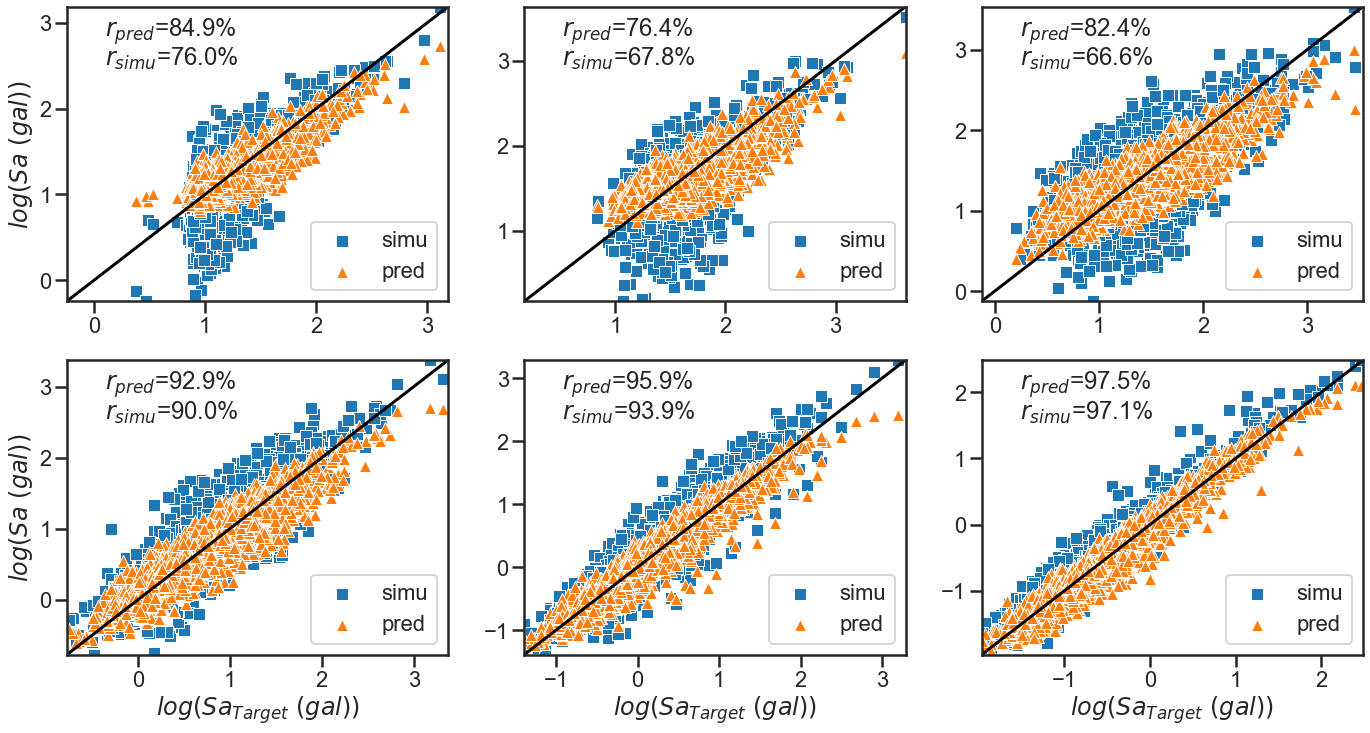

In [42]:
plt.figure(figsize=(18, 9))
plt.subplots_adjust(left=0,bottom=0,top=1,right=1,hspace=0.2,wspace=0.2)
for i, T in enumerate(period_sec):
    idx = np.argmin(np.abs(period - T))
    label_points = label[:, idx, 0]
    pred_points = pred[:, idx, 0]
    simu_points = simu[:, idx, 0]
    r_pred = np.corrcoef(label_points, pred_points)[0, 1]
    r_simu = np.corrcoef(label_points, simu_points)[0, 1]
    xmin = np.min([np.min(label_points), np.min(pred_points), np.min(simu_points)])
    xmax = np.max([np.max(label_points), np.max(pred_points), np.max(simu_points)])
    plt.subplot(2, 3, i + 1)
    sns.scatterplot(x=label_points, y=simu_points, label='simu', marker='s', color=colors[0])
    sns.scatterplot(x=label_points, y=pred_points, label='pred', marker='^', color=colors[1])
    plt.plot([xmin, xmax], [xmin, xmax], 'k', linewidth=3)
    plt.text(0.9 * xmin + 0.1 * xmax, 0.1 * xmin + 0.9 * xmax, '$r_{pred}$=%.1f%%' % (100 * r_pred), size=24)
    plt.text(0.9 * xmin + 0.1 * xmax, 0.2 * xmin + 0.8 * xmax, '$r_{simu}$=%.1f%%' % (100 * r_simu), size=24)
    plt.xlim([xmin, xmax])
    plt.ylim([xmin, xmax])
    if i >= 3:
        plt.xlabel('$log(Sa_{Target}\ (gal))$')
    if i in [0, 3]:
        plt.ylabel('$log(Sa\ (gal))$')
    # plt.xscale('log')
    # plt.yscale('log')
    plt.legend(loc='lower right')
plt.savefig(os.path.join(model_path, result_path, figure_path, 'Sa_T_compare.%s' % fig_fmt), dpi=300, bbox_inches='tight')

## 绘制残差分布图

### 残差随周期的分布图

C:\Users\LiL\AppData\Local\Temp/ipykernel_4396/3380740858.py:24: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.savefig(os.path.join(model_path, result_path, figure_path, 'residual_T.%s' % fig_fmt), dpi=300, bbox_inches='tight')
d:\application\Anaconda\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


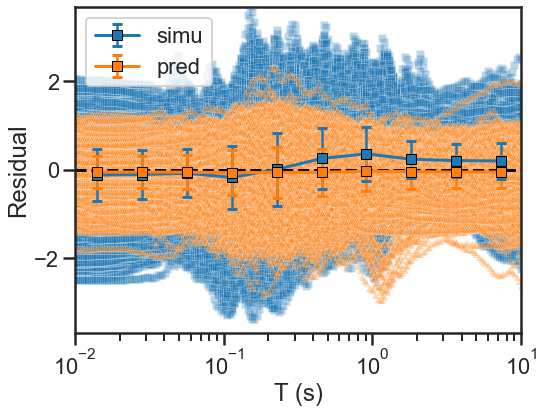

In [43]:
N = len(period)
num_bar = 10
t_err, mean_err_pred, std_err_pred, mean_err_simu, std_err_simu = np.zeros(num_bar), np.zeros(num_bar), np.zeros(num_bar), np.zeros(num_bar), np.zeros(num_bar)
for i in range(num_bar):
    t_err[i] = period[int((i + 0.5) * N / num_bar)]
    mean_err_pred[i] = np.mean(residual_pred[:, int(i * N / num_bar) : int((i + 1) * N / num_bar), 0])
    std_err_pred[i] = np.std(residual_pred[:, int(i * N / num_bar) : int((i + 1) * N / num_bar), 0])
    mean_err_simu[i] = np.mean(residual_simu[:, int(i * N / num_bar) : int((i + 1) * N / num_bar), 0])
    std_err_simu[i] = np.std(residual_simu[:, int(i * N / num_bar) : int((i + 1) * N / num_bar), 0])

ylim = np.max([np.max(np.abs(residual_pred)), np.max(np.abs(residual_simu))])
plt.figure(figsize=(8, 6))
plt.plot([np.min(period), np.max(period)], [0, 0], 'k--')
sns.scatterplot(x=np.tile(period, residual_simu.shape[0]), y=residual_simu[..., 0].ravel(), s=50, color=colors[0], marker='s', alpha=0.3)
plt.errorbar(t_err, mean_err_simu, std_err_simu, fmt='s-', ecolor=colors[0], ms=10, mfc=colors[0], mec='k', color=colors[0], elinewidth=2.5, capsize=5, capthick=3, label='simu')
sns.scatterplot(x=np.tile(period, residual_pred.shape[0]), y=residual_pred[..., 0].ravel(), s=50, color=colors[1], marker='^', alpha=0.3)
plt.errorbar(t_err, mean_err_pred, std_err_pred, fmt='s-', ecolor=colors[1], ms=10, mfc=colors[1], mec='k', color=colors[1], elinewidth=2.5, capsize=5, capthick=3, label='pred')
plt.xlim([np.min(period), np.max(period)])
plt.ylim([-ylim, ylim])
plt.xscale('log')
plt.xlabel('T (s)')
plt.ylabel('Residual')
plt.legend()
plt.savefig(os.path.join(model_path, result_path, figure_path, 'residual_T.%s' % fig_fmt), dpi=300, bbox_inches='tight')

### 残差随地表PGA的分布图

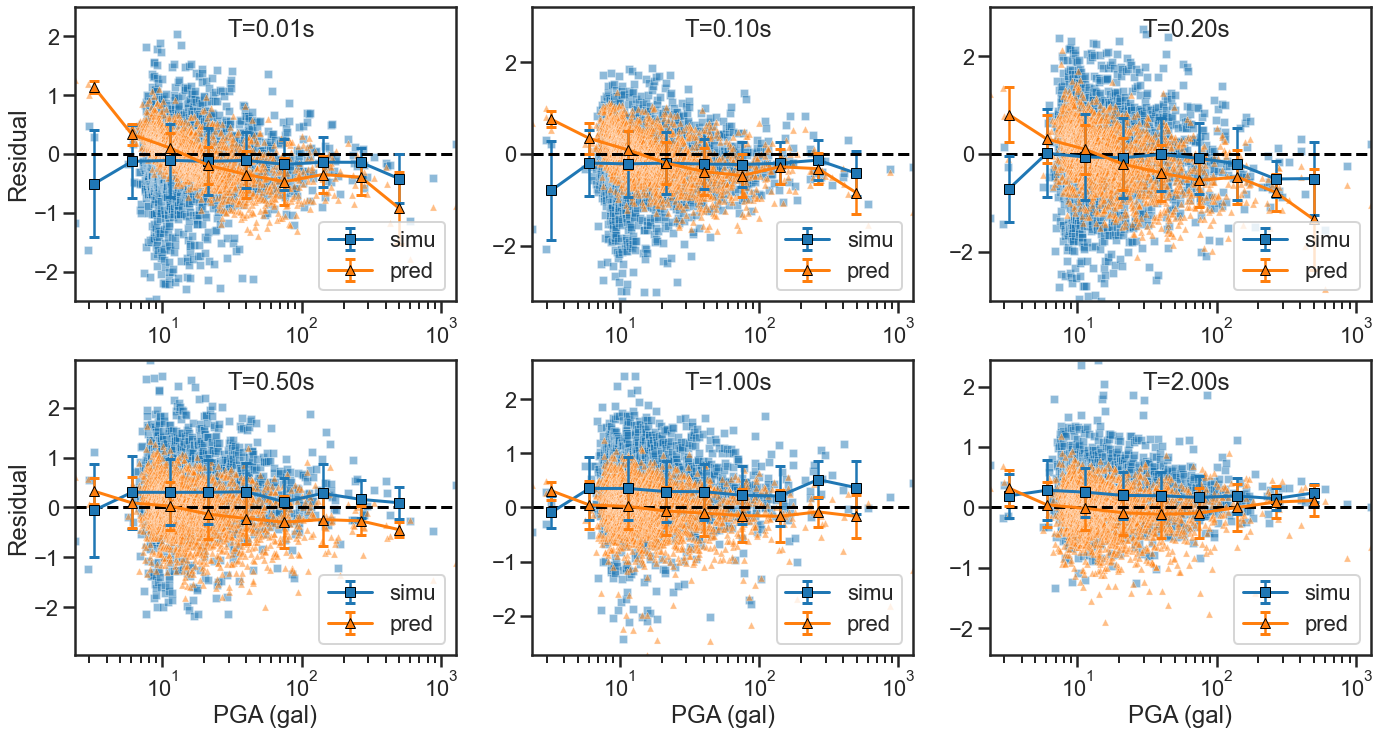

In [44]:
value_list = PGA

# 将所有地震的PGA按从小到大的顺序划分为10组，以便后面求解误差棒
value_min = np.min(value_list)
value_max = np.max(value_list)
num_bar = 10
value_step = (np.log(value_max) - np.log(value_min)) / num_bar
sort_idx = np.argsort(value_list)
value_list = value_list[sort_idx]
N = len(value_list)
idx_err = []
value_err = np.exp((np.arange(num_bar) + 0.5) * value_step + np.log(value_min))
for i in range(num_bar):
    idx = []
    for j, value in enumerate(value_list):
        if np.log(value) >= np.log(value_min) + i * value_step and np.log(value) < np.log(value_min) + (i + 1) * value_step:
            idx.append(j)
    idx_err.append(idx)

# 绘制残差随PGA的分布图和分组误差棒
plt.figure(figsize=(18, 9))
plt.subplots_adjust(left=0,bottom=0,top=1,right=1,hspace=0.2,wspace=0.2)
for i, T in enumerate(period_sec):
    idx = np.argmin(np.abs(period - T))
    residual_points_pred = residual_pred[:, idx, 0]
    residual_points_pred = residual_points_pred[sort_idx]
    residual_points_simu = residual_simu[:, idx, 0]
    residual_points_simu = residual_points_simu[sort_idx]
    ylim = np.max([np.max(np.abs(residual_points_pred)), np.max(np.abs(residual_points_simu))])

    mean_err_pred, std_err_pred, mean_err_simu, std_err_simu = np.zeros(num_bar), np.zeros(num_bar), np.zeros(num_bar), np.zeros(num_bar)
    for j in range(num_bar):
        mean_err_pred[j] = np.mean(residual_points_pred[idx_err[j]])
        std_err_pred[j] = np.std(residual_points_pred[idx_err[j]])
        mean_err_simu[j] = np.mean(residual_points_simu[idx_err[j]])
        std_err_simu[j] = np.std(residual_points_simu[idx_err[j]])

    plt.subplot(2, 3, i + 1)
    plt.plot([value_min, value_max], [0, 0], 'k--')
    sns.scatterplot(x=value_list, y=residual_points_simu, s=50, color=colors[0], marker='s', alpha=0.5)
    plt.errorbar(value_err[:-1], mean_err_simu[:-1], std_err_simu[:-1], fmt='s-', ecolor=colors[0], ms=10, mfc=colors[0], mec='k', color=colors[0], elinewidth=2.5, capsize=5, capthick=3, label='simu')

    sns.scatterplot(x=value_list, y=residual_points_pred, s=50, color=colors[1], marker='^', alpha=0.5)
    plt.errorbar(value_err[:-1], mean_err_pred[:-1], std_err_pred[:-1], fmt='^-', ecolor=colors[1], ms=10, mfc=colors[1], mec='k', color=colors[1], elinewidth=2.5, capsize=5, capthick=3, label='pred')
    plt.xlim([value_min, value_max])
    plt.ylim([-ylim, ylim])
    if i >= 3:
        plt.xlabel('PGA (gal)')
    if i in [0, 3]:
        plt.ylabel('Residual')
    plt.xscale('log')
    plt.legend(loc='lower right')
    plt.text(value_min ** 0.6 * value_max ** 0.4, 0.8 * ylim, 'T=%.2fs' % T, size=24)
plt.savefig(os.path.join(model_path, result_path, figure_path, 'residual_PGA.%s' % fig_fmt), dpi=300, bbox_inches='tight')

### 残差随$v_{s30}$的分布图

d:\application\Anaconda\lib\site-packages\numpy\core\fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
d:\application\Anaconda\lib\site-packages\numpy\core\_methods.py:188: RuntimeWarning: invalid value encountered in true_divide
  ret = ret.dtype.type(ret / rcount)
d:\application\Anaconda\lib\site-packages\numpy\core\_methods.py:261: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
d:\application\Anaconda\lib\site-packages\numpy\core\_methods.py:221: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
d:\application\Anaconda\lib\site-packages\numpy\core\_methods.py:253: RuntimeWarning: invalid value encountered in true_divide
  ret = ret.dtype.type(ret / rcount)
d:\application\Anaconda\lib\site-packages\numpy\core\_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
 

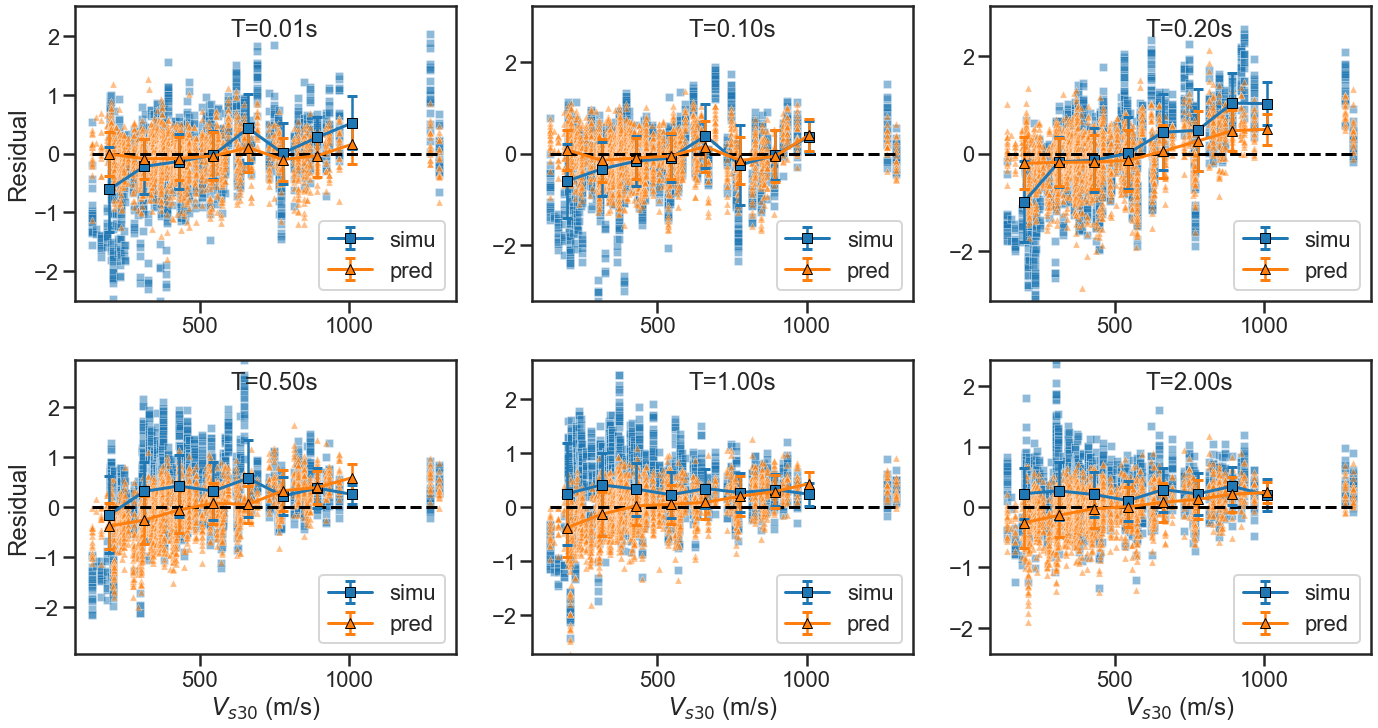

In [45]:
value_list = vs30

# 将所有地震对应的Vs30按从小到大的顺序划分为10组，以便后面求解误差棒
value_min = np.min(value_list)
value_max = np.max(value_list)
num_bar = 10
value_step = (value_max - value_min) / num_bar
sort_idx = np.argsort(value_list)
value_list = value_list[sort_idx]
N = len(value_list)
idx_err = []
value_err = value_min + (np.arange(num_bar) + 0.5) * value_step
for i in range(num_bar):
    idx = []
    for j, value in enumerate(value_list):
        if value >= value_min + i * value_step and value < value_min + (i + 1) * value_step:
            idx.append(j)
    idx_err.append(idx)

# 绘制残差随Vs30的分布图和分组误差棒
plt.figure(figsize=(18, 9))
plt.subplots_adjust(left=0,bottom=0,top=1,right=1,hspace=0.2,wspace=0.2)
for i, T in enumerate(period_sec):
    idx = np.argmin(np.abs(period - T))
    residual_points_pred = residual_pred[:, idx, 0]
    residual_points_pred = residual_points_pred[sort_idx]
    residual_points_simu = residual_simu[:, idx, 0]
    residual_points_simu = residual_points_simu[sort_idx]
    ylim = np.max([np.max(np.abs(residual_points_pred)), np.max(np.abs(residual_points_simu))])

    mean_err_pred, std_err_pred, mean_err_simu, std_err_simu = np.zeros(num_bar), np.zeros(num_bar), np.zeros(num_bar), np.zeros(num_bar)
    for j in range(num_bar):
        mean_err_pred[j] = np.mean(residual_points_pred[idx_err[j]])
        std_err_pred[j] = np.std(residual_points_pred[idx_err[j]])
        mean_err_simu[j] = np.mean(residual_points_simu[idx_err[j]])
        std_err_simu[j] = np.std(residual_points_simu[idx_err[j]])

    plt.subplot(2, 3, i + 1)
    plt.plot([value_min, value_max], [0, 0], 'k--')
    sns.scatterplot(x=value_list, y=residual_points_simu, s=50, color=colors[0], marker='s', alpha=0.5)
    plt.errorbar(value_err[:-1], mean_err_simu[:-1], std_err_simu[:-1], fmt='s-', ecolor=colors[0], ms=10, mfc=colors[0], mec='k', color=colors[0], elinewidth=2.5, capsize=5, capthick=3, label='simu')

    sns.scatterplot(x=value_list, y=residual_points_pred, s=50, color=colors[1], marker='^', alpha=0.5)
    plt.errorbar(value_err[:-1], mean_err_pred[:-1], std_err_pred[:-1], fmt='^-', ecolor=colors[1], ms=10, mfc=colors[1], mec='k', color=colors[1], elinewidth=2.5, capsize=5, capthick=3, label='pred')
    # plt.xlim([value_min, value_max])
    plt.ylim([-ylim, ylim])
    if i >= 3:
        plt.xlabel('$V_{s30}$ (m/s)')
    if i in [0, 3]:
        plt.ylabel('Residual')
    plt.legend(loc='lower right')
    plt.text(0.6 * value_min + 0.4 * value_max, 0.8 * ylim, 'T=%.2fs' % T, size=24)
plt.savefig(os.path.join(model_path, result_path, figure_path, 'residual_vs30.%s' % fig_fmt), dpi=300, bbox_inches='tight')

### 残差随震级的分布图

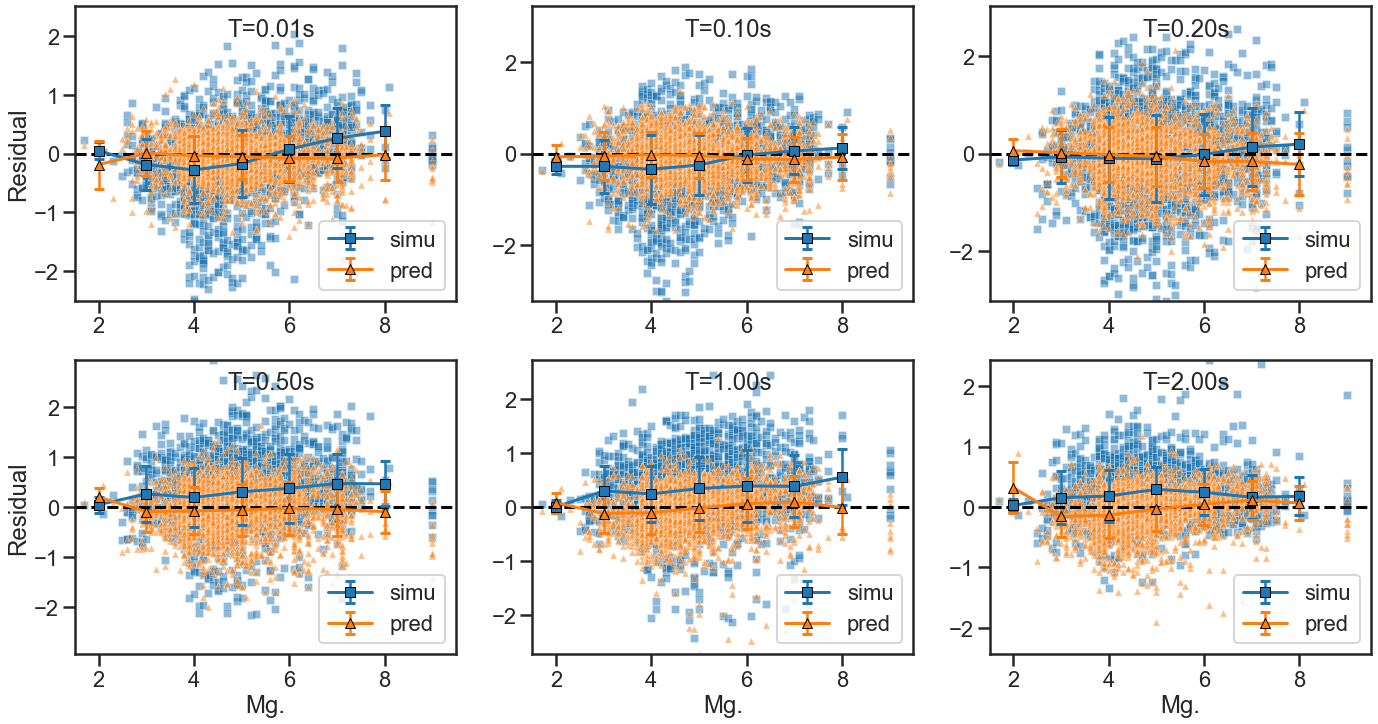

In [46]:
# 获取震级列表
value_list = source[:, 0]

# 将所有地震对应的震级按从小到大的顺序划分为10组，以便后面求解误差棒
value_min = np.round(np.min(value_list)) - 0.5
value_max = np.round(np.max(value_list)) + 0.5
value_step = 1
num_bar = int((value_max - value_min) / value_step)
sort_idx = np.argsort(value_list)
value_list = value_list[sort_idx]
N = len(value_list)
idx_err = []
value_err = np.arange(int(value_min + 0.5), int(value_max + 0.5))
for i in range(num_bar):
    idx = []
    for j, value in enumerate(value_list):
        if value >= value_min + i * value_step and value < value_min + (i + 1) * value_step:
            idx.append(j)
    idx_err.append(idx)

# 绘制残差随震级的分布图和分组误差棒
plt.figure(figsize=(18, 9))
plt.subplots_adjust(left=0,bottom=0,top=1,right=1,hspace=0.2,wspace=0.2)
for i, T in enumerate(period_sec):
    idx = np.argmin(np.abs(period - T))
    residual_points_pred = residual_pred[:, idx, 0]
    residual_points_pred = residual_points_pred[sort_idx]
    residual_points_simu = residual_simu[:, idx, 0]
    residual_points_simu = residual_points_simu[sort_idx]
    ylim = np.max([np.max(np.abs(residual_points_pred)), np.max(np.abs(residual_points_simu))])

    mean_err_pred, std_err_pred, mean_err_simu, std_err_simu = np.zeros(num_bar), np.zeros(num_bar), np.zeros(num_bar), np.zeros(num_bar)
    for j in range(num_bar):
        mean_err_pred[j] = np.mean(residual_points_pred[idx_err[j]])
        std_err_pred[j] = np.std(residual_points_pred[idx_err[j]])
        mean_err_simu[j] = np.mean(residual_points_simu[idx_err[j]])
        std_err_simu[j] = np.std(residual_points_simu[idx_err[j]])

    plt.subplot(2, 3, i + 1)
    plt.plot([value_min, value_max], [0, 0], 'k--')
    sns.scatterplot(x=value_list, y=residual_points_simu, s=50, color=colors[0], marker='s', alpha=0.5)
    plt.errorbar(value_err[:-1], mean_err_simu[:-1], std_err_simu[:-1], fmt='s-', ecolor=colors[0], ms=10, mfc=colors[0], mec='k', color=colors[0], elinewidth=2.5, capsize=5, capthick=3, label='simu')

    sns.scatterplot(x=value_list, y=residual_points_pred, s=50, color=colors[1], marker='^', alpha=0.5)
    plt.errorbar(value_err[:-1], mean_err_pred[:-1], std_err_pred[:-1], fmt='^-', ecolor=colors[1], ms=10, mfc=colors[1], mec='k', color=colors[1], elinewidth=2.5, capsize=5, capthick=3, label='pred')
    plt.xlim([value_min, value_max])
    plt.ylim([-ylim, ylim])
    if i >= 3:
        plt.xlabel('Mg.')
    if i in [0, 3]:
        plt.ylabel('Residual')
    plt.legend(loc='lower right')
    plt.text(0.6 * value_min + 0.4 * value_max, 0.8 * ylim, 'T=%.2fs' % T, size=24)
plt.savefig(os.path.join(model_path, result_path, figure_path, 'residual_Mg.%s' % fig_fmt), dpi=300, bbox_inches='tight')

### 残差随震源深度的分布图

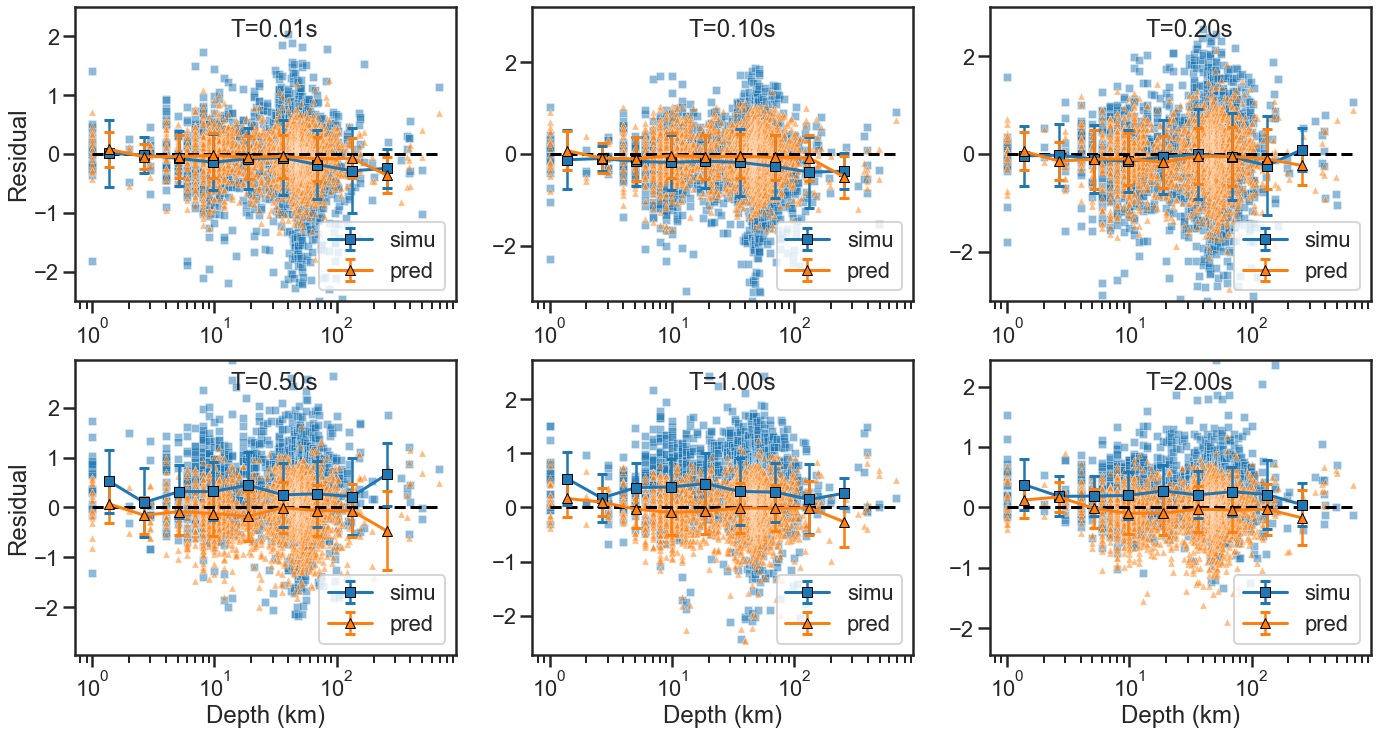

In [47]:
# 获取震源深度列表
depth_list = source[:, 1]
depth_list[depth_list < 1.0] = 1.0
value_list = depth_list

# 将所有地震对应的震源深度按从小到大的顺序划分为10组，以便后面求解误差棒
value_min = np.min(value_list)
value_max = np.max(value_list)
num_bar = 10
value_step = (np.log(value_max) - np.log(value_min)) / num_bar
sort_idx = np.argsort(value_list)
value_list = value_list[sort_idx]
N = len(value_list)
idx_err = []
value_err = np.exp(np.log(value_min) + (np.arange(num_bar) + 0.5) * value_step)
for i in range(num_bar):
    idx = []
    for j, value in enumerate(value_list):
        if np.log(value) >= np.log(value_min) + i * value_step and np.log(value) < np.log(value_min) + (i + 1) * value_step:
            idx.append(j)
    idx_err.append(idx)

# 绘制残差随震源深度的分布图和分组误差棒
plt.figure(figsize=(18, 9))
plt.subplots_adjust(left=0,bottom=0,top=1,right=1,hspace=0.2,wspace=0.2)
for i, T in enumerate(period_sec):
    idx = np.argmin(np.abs(period - T))
    residual_points_pred = residual_pred[:, idx, 0]
    residual_points_pred = residual_points_pred[sort_idx]
    residual_points_simu = residual_simu[:, idx, 0]
    residual_points_simu = residual_points_simu[sort_idx]
    ylim = np.max([np.max(np.abs(residual_points_pred)), np.max(np.abs(residual_points_simu))])

    mean_err_pred, std_err_pred, mean_err_simu, std_err_simu = np.zeros(num_bar), np.zeros(num_bar), np.zeros(num_bar), np.zeros(num_bar)
    for j in range(num_bar):
        mean_err_pred[j] = np.mean(residual_points_pred[idx_err[j]])
        std_err_pred[j] = np.std(residual_points_pred[idx_err[j]])
        mean_err_simu[j] = np.mean(residual_points_simu[idx_err[j]])
        std_err_simu[j] = np.std(residual_points_simu[idx_err[j]])

    plt.subplot(2, 3, i + 1)
    plt.plot([value_min, value_max], [0, 0], 'k--')
    sns.scatterplot(x=value_list, y=residual_points_simu, s=50, color=colors[0], marker='s', alpha=0.5)
    plt.errorbar(value_err[:-1], mean_err_simu[:-1], std_err_simu[:-1], fmt='s-', ecolor=colors[0], ms=10, mfc=colors[0], mec='k', color=colors[0], elinewidth=2.5, capsize=5, capthick=3, label='simu')

    sns.scatterplot(x=value_list, y=residual_points_pred, s=50, color=colors[1], marker='^', alpha=0.5)
    plt.errorbar(value_err[:-1], mean_err_pred[:-1], std_err_pred[:-1], fmt='^-', ecolor=colors[1], ms=10, mfc=colors[1], mec='k', color=colors[1], elinewidth=2.5, capsize=5, capthick=3, label='pred')
    # plt.xlim([value_min, value_max])
    plt.ylim([-ylim, ylim])
    if i >= 3:
        plt.xlabel('Depth (km)')
    if i in [0, 3]:
        plt.ylabel('Residual')
    plt.xscale('log')
    plt.legend(loc='lower right')
    plt.text(value_min ** 0.6 * value_max ** 0.4, 0.8 * ylim, 'T=%.2fs' % T, size=24)
plt.savefig(os.path.join(model_path, result_path, figure_path, 'residual_Depth.%s' % fig_fmt), dpi=300, bbox_inches='tight')

### 残差随震中距的分布图

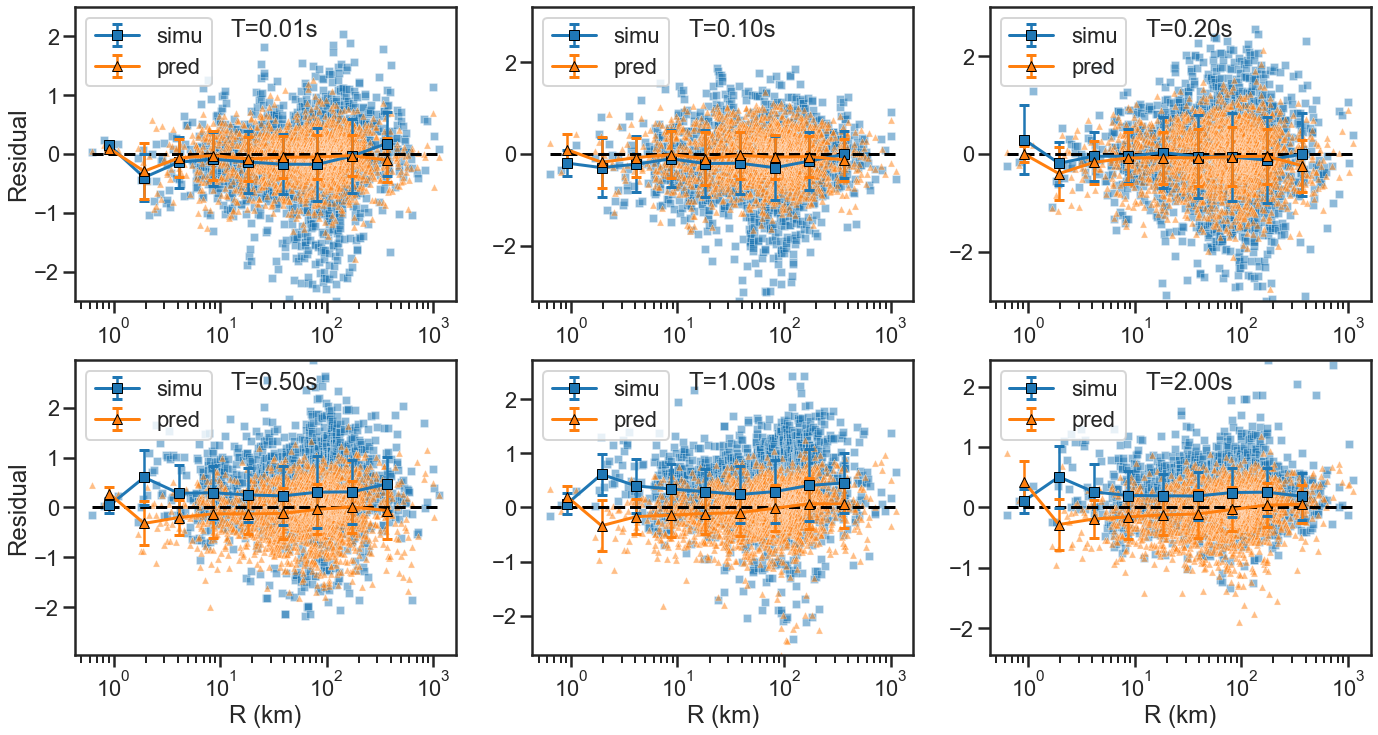

In [48]:
# 获取震中距列表
value_list = source[:, 2]

# 将所有地震对应的震中距按从小到大的顺序划分为10组，以便后面求解误差棒
value_min = np.min(value_list)
value_max = np.max(value_list)
num_bar = 10
value_step = (np.log(value_max) - np.log(value_min)) / num_bar
sort_idx = np.argsort(value_list)
value_list = value_list[sort_idx]
N = len(value_list)
idx_err = []
value_err = np.exp(np.log(value_min) + (np.arange(num_bar) + 0.5) * value_step)
for i in range(num_bar):
    idx = []
    for j, value in enumerate(value_list):
        if np.log(value) >= np.log(value_min) + i * value_step and np.log(value) < np.log(value_min) + (i + 1) * value_step:
            idx.append(j)
    idx_err.append(idx)

# 绘制残差随震中距的分布图和分组误差棒
plt.figure(figsize=(18, 9))
plt.subplots_adjust(left=0,bottom=0,top=1,right=1,hspace=0.2,wspace=0.2)
for i, T in enumerate(period_sec):
    idx = np.argmin(np.abs(period - T))
    residual_points_pred = residual_pred[:, idx, 0]
    residual_points_pred = residual_points_pred[sort_idx]
    residual_points_simu = residual_simu[:, idx, 0]
    residual_points_simu = residual_points_simu[sort_idx]
    ylim = np.max([np.max(np.abs(residual_points_pred)), np.max(np.abs(residual_points_simu))])

    mean_err_pred, std_err_pred, mean_err_simu, std_err_simu = np.zeros(num_bar), np.zeros(num_bar), np.zeros(num_bar), np.zeros(num_bar)
    for j in range(num_bar):
        mean_err_pred[j] = np.mean(residual_points_pred[idx_err[j]])
        std_err_pred[j] = np.std(residual_points_pred[idx_err[j]])
        mean_err_simu[j] = np.mean(residual_points_simu[idx_err[j]])
        std_err_simu[j] = np.std(residual_points_simu[idx_err[j]])

    plt.subplot(2, 3, i + 1)
    plt.plot([value_min, value_max], [0, 0], 'k--')
    sns.scatterplot(x=value_list, y=residual_points_simu, s=50, color=colors[0], marker='s', alpha=0.5)
    plt.errorbar(value_err[:-1], mean_err_simu[:-1], std_err_simu[:-1], fmt='s-', ecolor=colors[0], ms=10, mfc=colors[0], mec='k', color=colors[0], elinewidth=2.5, capsize=5, capthick=3, label='simu')

    sns.scatterplot(x=value_list, y=residual_points_pred, s=50, color=colors[1], marker='^', alpha=0.5)
    plt.errorbar(value_err[:-1], mean_err_pred[:-1], std_err_pred[:-1], fmt='^-', ecolor=colors[1], ms=10, mfc=colors[1], mec='k', color=colors[1], elinewidth=2.5, capsize=5, capthick=3, label='pred')
    # plt.xlim([value_min, value_max])
    plt.ylim([-ylim, ylim])
    if i >= 3:
        plt.xlabel('R (km)')
    if i in [0, 3]:
        plt.ylabel('Residual')
    plt.xscale('log')
    plt.legend(loc='upper left')
    plt.text(value_min ** 0.6 * value_max ** 0.4, 0.8 * ylim, 'T=%.2fs' % T, size=24)
plt.savefig(os.path.join(model_path, result_path, figure_path, 'residual_Rup.%s' % fig_fmt), dpi=300, bbox_inches='tight')

## 绘制label和prediction的散点对比图

### 随周期的变化图

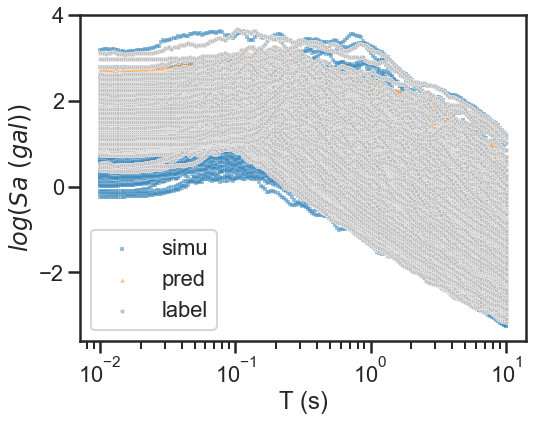

In [49]:
ymin = np.min([np.min(label[..., 0].ravel()), np.min(pred[..., 0].ravel()), np.min(simu[..., 0].ravel())])
ymax = np.max([np.max(label[..., 0].ravel()), np.max(pred[..., 0].ravel()), np.max(simu[..., 0].ravel())])
plt.figure(figsize=(8, 6))
sns.scatterplot(x=np.tile(period, label.shape[0]), y=simu[..., 0].ravel(), s=20, label='simu', marker='s', color=colors[0], alpha=0.5)
sns.scatterplot(x=np.tile(period, label.shape[0]), y=pred[..., 0].ravel(), s=20, label='pred', marker='^', color=colors[1], alpha=0.5)
sns.scatterplot(x=np.tile(period, label.shape[0]), y=label[..., 0].ravel(), s=20, label='label', marker='o', color='silver')
# plt.ylim([ymin, 0.2 * ymax])
plt.xscale('log')
plt.xlabel('T (s)')
plt.ylabel('$log(Sa\ (gal))$')
plt.legend()
plt.savefig(os.path.join(model_path, result_path, figure_path, 'Sa_scatter_T.%s' % fig_fmt), dpi=300, bbox_inches='tight')

### 随地表PGA的变化图

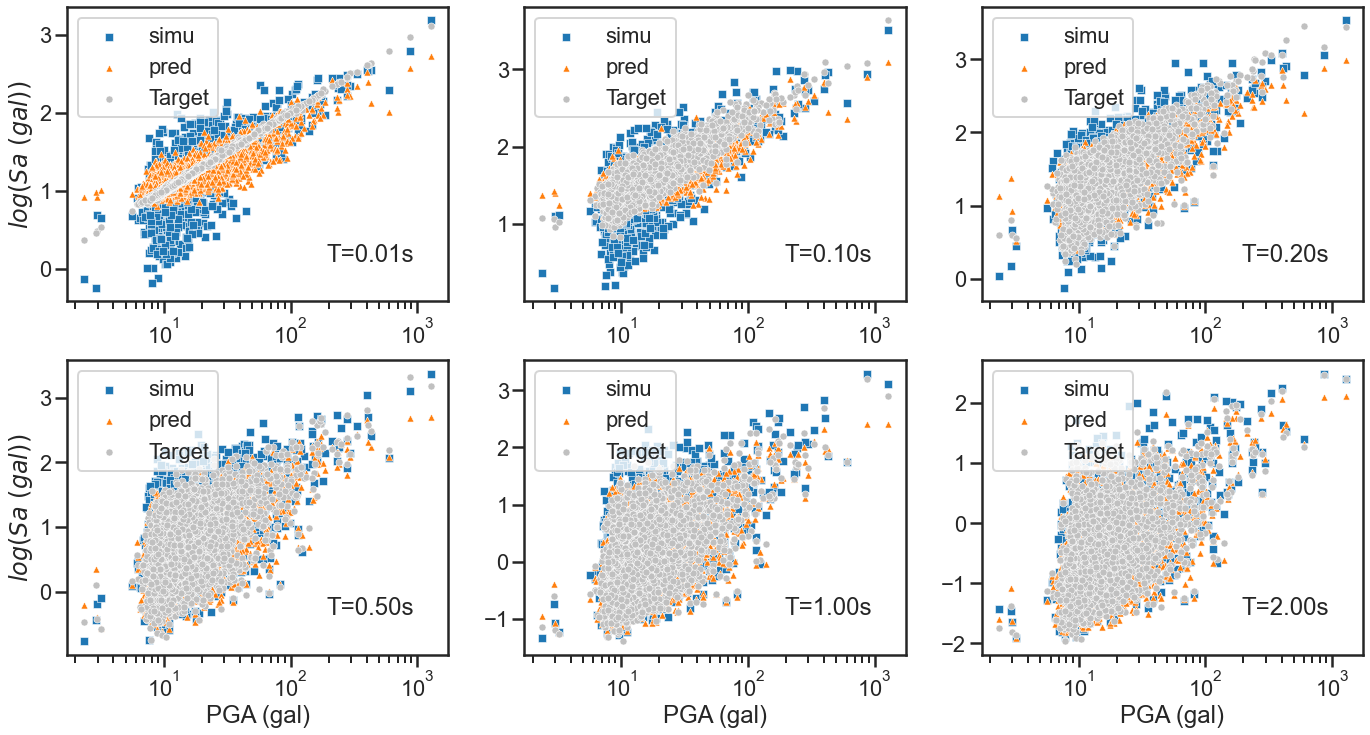

In [50]:
value_list = PGA

value_min = np.min(value_list)
value_max = np.max(value_list)

plt.figure(figsize=(18, 9))
plt.subplots_adjust(left=0,bottom=0,top=1,right=1,hspace=0.2,wspace=0.2)
for i, T in enumerate(period_sec):
    idx = np.argmin(np.abs(period - T))
    label_points = label[:, idx, 0]
    pred_points = pred[:, idx, 0]
    simu_points = simu[:, idx, 0]
    ymin = np.min([np.min(label_points), np.min(pred_points), np.min(simu_points)])
    ymax = np.max([np.max(label_points), np.max(pred_points), np.max(simu_points)])

    plt.subplot(2, 3, i + 1)
    sns.scatterplot(x=value_list, y=simu_points, label='simu', s=50, marker='s', color=colors[0])
    sns.scatterplot(x=value_list, y=pred_points, label='pred', s=50, marker='^', color=colors[1])
    sns.scatterplot(x=value_list, y=label_points, label='Target', s=50, marker='o', color='silver')
    plt.text(value_min ** 0.3 * value_max ** 0.7, ymin + 0.1 * (ymax - ymin), 'T=%.2fs' % T, size=24)
    # plt.xlim([value_min, value_max])
    # plt.ylim([ymin, ymax])
    if i >= 3:
        plt.xlabel('PGA (gal)')
    if i in [0, 3]:
        plt.ylabel('$log(Sa\ (gal))$')
    plt.xscale('log')
    plt.legend(loc='upper left')
plt.savefig(os.path.join(model_path, result_path, figure_path, 'Sa_scatter_PGA.%s' % fig_fmt), dpi=300, bbox_inches='tight')

### 随$v_{s30}$的变化图

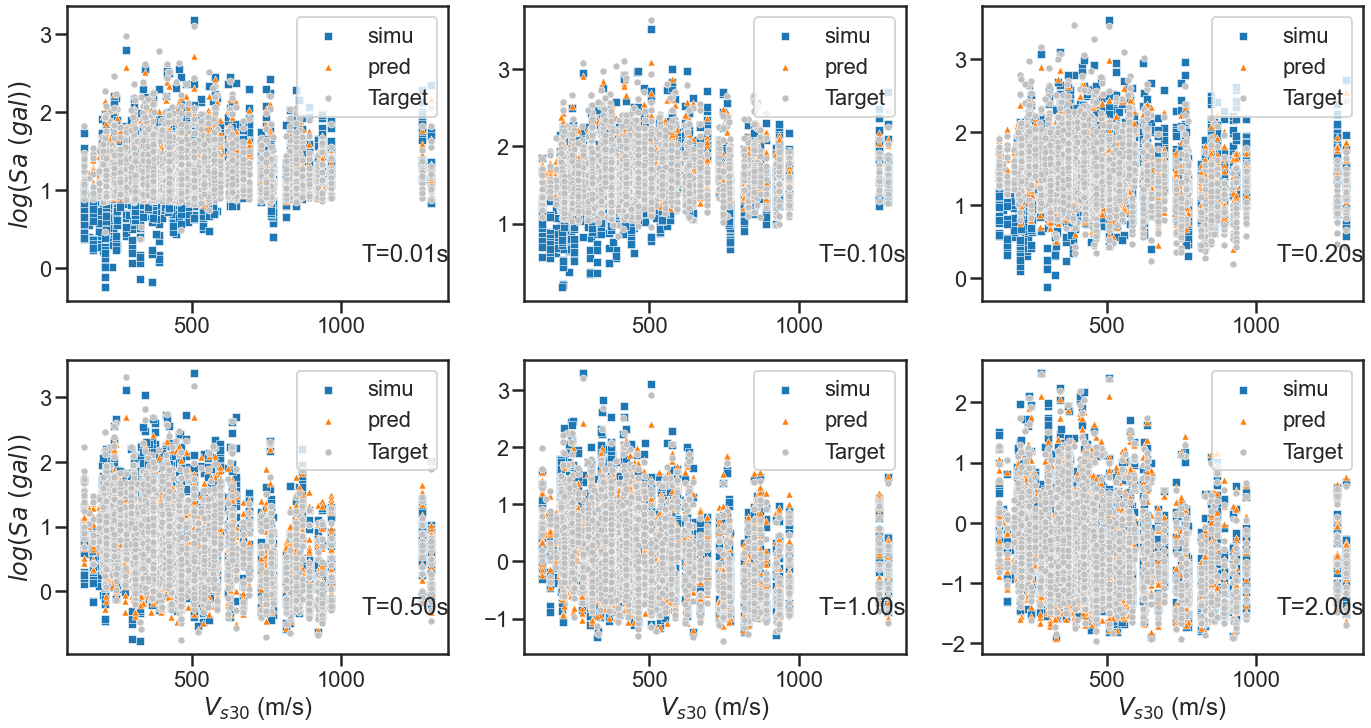

In [51]:
# 加载vs30数据并获取数据集中每条地震动对应的Vs30值
value_list = vs30

value_min = np.min(value_list)
value_max = np.max(value_list)

plt.figure(figsize=(18, 9))
plt.subplots_adjust(left=0,bottom=0,top=1,right=1,hspace=0.2,wspace=0.2)
for i, T in enumerate(period_sec):
    idx = np.argmin(np.abs(period - T))
    label_points = label[:, idx, 0]
    pred_points = pred[:, idx, 0]
    simu_points = simu[:, idx, 0]
    ymin = np.min([np.min(label_points), np.min(pred_points), np.min(simu_points)])
    ymax = np.max([np.max(label_points), np.max(pred_points), np.max(simu_points)])

    plt.subplot(2, 3, i + 1)
    sns.scatterplot(x=value_list, y=simu_points, label='simu', s=50, marker='s', color=colors[0])
    sns.scatterplot(x=value_list, y=pred_points, label='pred', s=50, marker='^', color=colors[1])
    sns.scatterplot(x=value_list, y=label_points, label='Target', s=50, marker='o', color='silver')
    plt.text(value_max - 0.2 * (value_max - value_min), ymin + 0.1 * (ymax - ymin), 'T=%.2fs' % T, size=24)
    # plt.xlim([value_min - 0.05 * (value_max - value_min), value_max + 0.05 * (value_max - value_min)])
    # plt.ylim([ymin, ymax])
    if i >= 3:
        plt.xlabel('$V_{s30}$ (m/s)')
    if i in [0, 3]:
        plt.ylabel('$log(Sa\ (gal))$')
    plt.legend(loc='upper right')
plt.savefig(os.path.join(model_path, result_path, figure_path, 'Sa_scatter_vs30.%s' % fig_fmt), dpi=300, bbox_inches='tight')

### 随震级的变化图

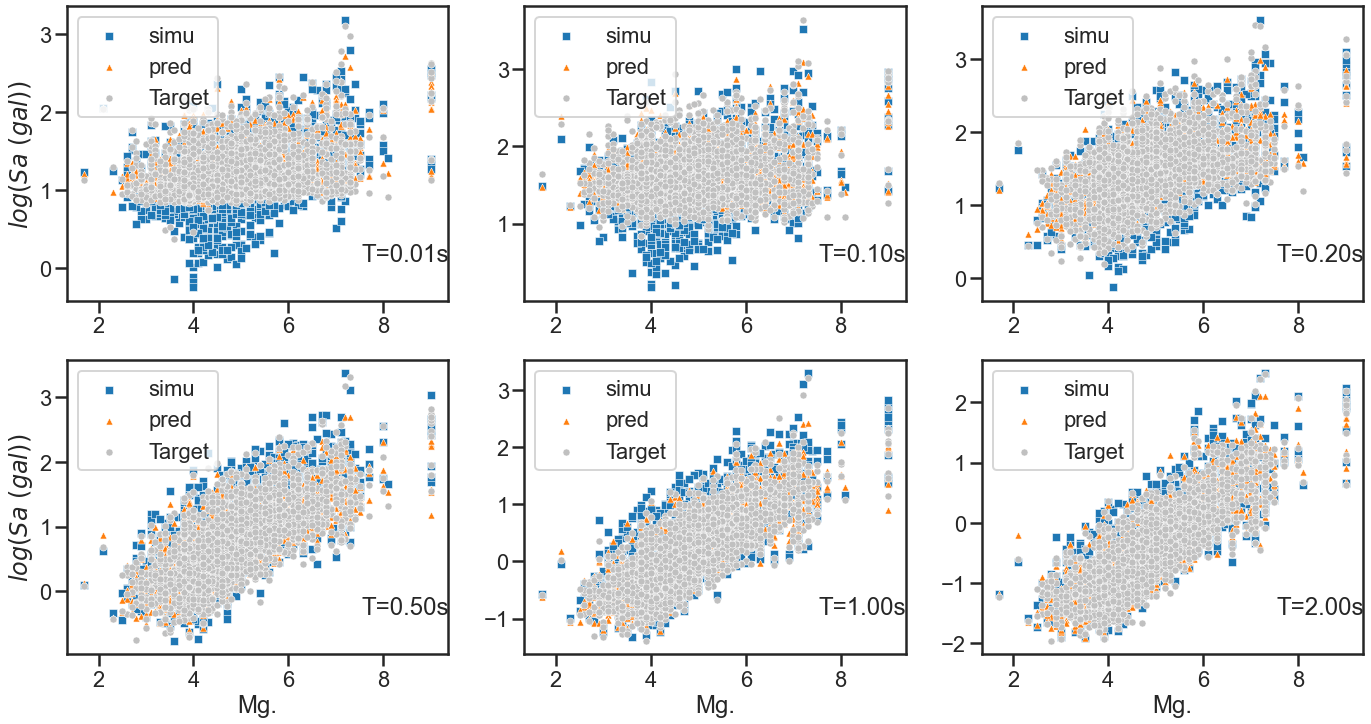

In [52]:
# 获取震级列表
value_list = source[:, 0]

value_min = np.min(value_list)
value_max = np.max(value_list)

plt.figure(figsize=(18, 9))
plt.subplots_adjust(left=0,bottom=0,top=1,right=1,hspace=0.2,wspace=0.2)
for i, T in enumerate(period_sec):
    idx = np.argmin(np.abs(period - T))
    label_points = label[:, idx, 0]
    pred_points = pred[:, idx, 0]
    simu_points = simu[:, idx, 0]
    ymin = np.min([np.min(label_points), np.min(pred_points), np.min(simu_points)])
    ymax = np.max([np.max(label_points), np.max(pred_points), np.max(simu_points)])

    plt.subplot(2, 3, i + 1)
    sns.scatterplot(x=value_list, y=simu_points, label='simu', s=50, marker='s', color=colors[0])
    sns.scatterplot(x=value_list, y=pred_points, label='pred', s=50, marker='^', color=colors[1])
    sns.scatterplot(x=value_list, y=label_points, label='Target', s=50, marker='o', color='silver')
    plt.text(value_max - 0.2 * (value_max - value_min), ymin + 0.1 * (ymax - ymin), 'T=%.2fs' % T, size=24)
    # plt.xlim([value_min - 0.05 * (value_max - value_min), value_max + 0.05 * (value_max - value_min)])
    # plt.ylim([ymin, ymax])
    if i >= 3:
        plt.xlabel('Mg.')
    if i in [0, 3]:
        plt.ylabel('$log(Sa\ (gal))$')
    plt.legend(loc='upper left')
plt.savefig(os.path.join(model_path, result_path, figure_path, 'Sa_scatter_Mg.%s' % fig_fmt), dpi=300, bbox_inches='tight')

### 随震源深度的变化图

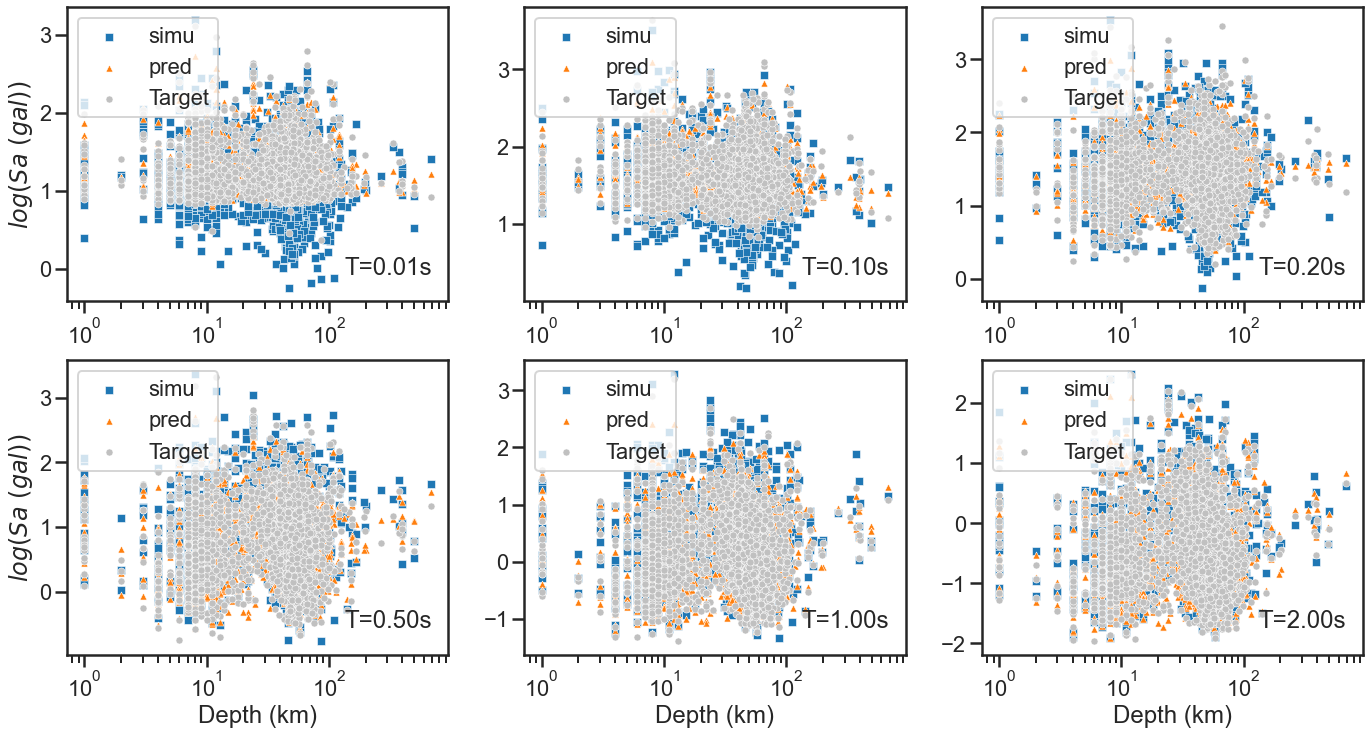

In [53]:
# 获取震源深度列表
value_list = source[:, 1]
value_list[value_list < 1.0] = 1.0

value_min = np.min(value_list)
value_max = np.max(value_list)

plt.figure(figsize=(18, 9))
plt.subplots_adjust(left=0,bottom=0,top=1,right=1,hspace=0.2,wspace=0.2)
for i, T in enumerate(period_sec):
    idx = np.argmin(np.abs(period - T))
    label_points = label[:, idx, 0]
    pred_points = pred[:, idx, 0]
    simu_points = simu[:, idx, 0]
    ymin = np.min([np.min(label_points), np.min(pred_points), np.min(simu_points)])
    ymax = np.max([np.max(label_points), np.max(pred_points), np.max(simu_points)])

    plt.subplot(2, 3, i + 1)
    sns.scatterplot(x=value_list, y=simu_points, label='simu', s=50, marker='s', color=colors[0])
    sns.scatterplot(x=value_list, y=pred_points, label='pred', s=50, marker='^', color=colors[1])
    sns.scatterplot(x=value_list, y=label_points, label='Target', s=50, marker='o', color='silver')
    plt.text(value_max ** 0.75 * value_min ** 0.25, ymin + 0.05 * (ymax - ymin), 'T=%.2fs' % T, size=24)
    # plt.xlim([value_min - 0.05 * (value_max - value_min), value_max + 0.05 * (value_max - value_min)])
    # plt.ylim([ymin, ymax])
    if i >= 3:
        plt.xlabel('Depth (km)')
    if i in [0, 3]:
        plt.ylabel('$log(Sa\ (gal))$')
    plt.xscale('log')
    plt.legend(loc='upper left')
plt.savefig(os.path.join(model_path, result_path, figure_path, 'Sa_scatter_Depth.%s' % fig_fmt), dpi=300, bbox_inches='tight')

### 随震中距的变化图

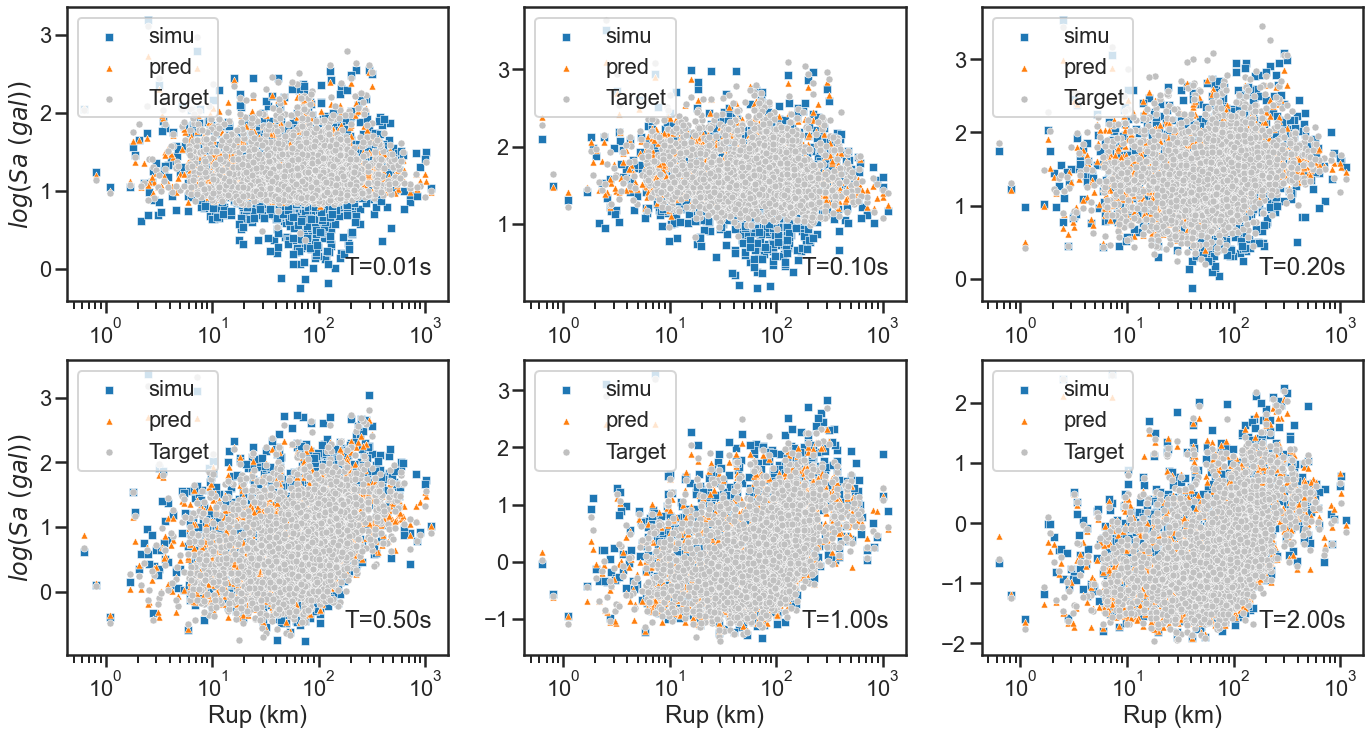

In [54]:
# 获取震中距列表
value_list = source[:, 2]
value_min = np.min(value_list)
value_max = np.max(value_list)

plt.figure(figsize=(18, 9))
plt.subplots_adjust(left=0,bottom=0,top=1,right=1,hspace=0.2,wspace=0.2)
for i, T in enumerate(period_sec):
    idx = np.argmin(np.abs(period - T))
    label_points = label[:, idx, 0]
    pred_points = pred[:, idx, 0]
    simu_points = simu[:, idx, 0]
    ymin = np.min([np.min(label_points), np.min(pred_points), np.min(simu_points)])
    ymax = np.max([np.max(label_points), np.max(pred_points), np.max(simu_points)])

    plt.subplot(2, 3, i + 1)
    sns.scatterplot(x=value_list, y=simu_points, label='simu', s=50, marker='s', color=colors[0])
    sns.scatterplot(x=value_list, y=pred_points, label='pred', s=50, marker='^', color=colors[1])
    sns.scatterplot(x=value_list, y=label_points, label='Target', s=50, marker='o', color='silver')
    plt.text(value_max ** 0.75 * value_min ** 0.25, ymin + 0.05 * (ymax - ymin), 'T=%.2fs' % T, size=24)
    # plt.xlim([value_min - 0.05 * (value_max - value_min), value_max + 0.05 * (value_max - value_min)])
    # plt.ylim([ymin, ymax])
    if i >= 3:
        plt.xlabel('Rup (km)')
    if i in [0, 3]:
        plt.ylabel('$log(Sa\ (gal))$')
    plt.xscale('log')
    plt.legend(loc='upper left')
plt.savefig(os.path.join(model_path, result_path, figure_path, 'Sa_scatter_Rup.%s' % fig_fmt), dpi=300, bbox_inches='tight')

# 特征周期或频率上的对比

## 提取特征周期或频率

In [ ]:
predominant = pd.read_excel('predominant.xlsx')
period1, freq1 = [], []
pbar = tqdm(range(dataset.test_label.shape[0]), desc='Processing', ncols=100)
for i in pbar:
    event = dataset.test_events[dataset.test_idx[i]]
    pbar.set_description(event)
    if event in event_simu:
        period1.append(float(predominant[predominant['station'] == event[:6]]['period (s)']))
        freq1.append(float(predominant[predominant['station'] == event[:6]]['freq (Hz)']))
period1 = np.array(period1)
freq1 = np.array(freq1)

## 特征周期和频率上的残差分布

In [ ]:
value_list = period1

# 将所有地震的特征周期按从小到大的顺序划分为10组，以便后面求解误差棒
value_min = np.min(value_list)
value_max = np.max(value_list)
num_bar = 10
value_step = (np.log(value_max) - np.log(value_min)) / num_bar
sort_idx = np.argsort(value_list)
value_list = value_list[sort_idx]
N = len(value_list)
idx_err = []
value_err = np.exp((np.arange(num_bar) + 0.5) * value_step + np.log(value_min))
for i in range(num_bar):
    idx = []
    for j, value in enumerate(value_list):
        if np.log(value) >= np.log(value_min) + i * value_step and np.log(value) < np.log(value_min) + (i + 1) * value_step:
            idx.append(j)
    idx_err.append(idx)

# 绘制残差随特征周期的分布图和分组误差棒
residual_points_pred, residual_points_simu = np.zeros(len(value_list)), np.zeros(len(value_list))
for i, T in enumerate(value_list):
    idx = np.argmin(np.abs(period - T))
    residual_points_pred[i] = residual_pred[i, idx, 0]
    residual_points_simu[i] = residual_simu[i, idx, 0]
ylim = np.max([np.max(np.abs(residual_points_pred)), np.max(np.abs(residual_points_simu))])

mean_err_pred, std_err_pred, mean_err_simu, std_err_simu = np.zeros(num_bar), np.zeros(num_bar), np.zeros(num_bar), np.zeros(num_bar)
for j in range(num_bar):
    mean_err_pred[j] = np.mean(residual_points_pred[idx_err[j]])
    std_err_pred[j] = np.std(residual_points_pred[idx_err[j]])
    mean_err_simu[j] = np.mean(residual_points_simu[idx_err[j]])
    std_err_simu[j] = np.std(residual_points_simu[idx_err[j]])

plt.figure(figsize=(8, 6))
plt.plot([value_min, value_max], [0, 0], 'k--')
sns.scatterplot(x=value_list, y=residual_points_simu, s=50, color=colors[0], marker='s', alpha=0.5)
plt.errorbar(value_err[:-1], mean_err_simu[:-1], std_err_simu[:-1], fmt='s-', ecolor=colors[0], ms=10, mfc=colors[0], mec='k', color=colors[0], elinewidth=2.5, capsize=5, capthick=3, label='simu')

sns.scatterplot(x=value_list, y=residual_points_pred, s=50, color=colors[1], marker='^', alpha=0.5)
plt.errorbar(value_err[:-1], mean_err_pred[:-1], std_err_pred[:-1], fmt='^-', ecolor=colors[1], ms=10, mfc=colors[1], mec='k', color=colors[1], elinewidth=2.5, capsize=5, capthick=3, label='pred')
# plt.xlim([value_min, value_max])
plt.ylim([-ylim, ylim])
plt.xscale('log')
plt.xlabel('Period (s)')
plt.ylabel('Residual')
plt.legend(loc='lower right')
plt.savefig(os.path.join(model_path, result_path, figure_path, 'residual_predominant.%s' % fig_fmt), dpi=300, bbox_inches='tight')

## 特征周期和频率上的预测和实测对比图

In [ ]:
value_list = period1

value_min = np.min(value_list)
value_max = np.max(value_list)

label_points, pred_points, simu_points = np.zeros(len(value_list)), np.zeros(len(value_list)), np.zeros(len(value_list))
for i, T in enumerate(value_list):
    idx = np.argmin(np.abs(period - T))
    label_points[i] = label[i, idx, 0]
    pred_points[i] = pred[i, idx, 0]
    simu_points[i] = simu[i, idx, 0]
ymin = np.min([np.min(label_points), np.min(pred_points), np.min(simu_points)])
ymax = np.max([np.max(label_points), np.max(pred_points), np.max(simu_points)])

plt.figure(figsize=(8, 6))

sns.scatterplot(x=value_list, y=simu_points, label='simu', s=50, marker='s', color=colors[0])
sns.scatterplot(x=value_list, y=pred_points, label='pred', s=50, marker='^', color=colors[1])
sns.scatterplot(x=value_list, y=label_points, label='Target', s=50, marker='o', color='silver')
# plt.xlim([value_min, value_max])
# plt.ylim([ymin, ymax])
plt.xlabel('Period (s)')
plt.ylabel('$log(Sa\ (gal))$')
plt.xscale('log')
# plt.legend(loc='upper left')
plt.savefig(os.path.join(model_path, result_path, figure_path, 'Sa_scatter_predominant.%s' % fig_fmt), dpi=300, bbox_inches='tight')

# 不同通道模型与有限元模型的整体对比

In [59]:
with open(os.path.join('inp_arg3_model_events', 'data_preprocess_100class_logsa.pkl'), 'rb') as file:
    dataset = pickle.loads(file.read())
results1 = scipy.io.loadmat(os.path.join('inp_arg1_model_events', 'basic_1inps_100class_logsa5', 'result.mat'))
results2 = scipy.io.loadmat(os.path.join('inp_arg2_model_events', 'basic_2inps_100class_logsa5', 'result.mat'))
results3 = scipy.io.loadmat(os.path.join('inp_arg3_model_events', 'basic_3inps_100class_logsa5', 'result.mat'))
period = np.logspace(np.log10(0.01), np.log10(10), 200)
fig_path = 'compare_figs_events'
fig_fmt = 'png'

In [60]:
# 获取数据
period_sec = [0.01, 0.1, 0.2, 0.5, 1.0, 2.0]
event_msg = np.load('event_msg.npy', allow_pickle=True).item()
vs30_data = np.load('vs30.npy', allow_pickle=True).item()
source_data = np.load('source.npy', allow_pickle=True).item()
simu_data = np.load('Sa_simulate.npy', allow_pickle=True).item()
label, pred1, pred2, pred3, simu = [], [], [], [], []
PGA, vs30, source= [], [], []
event_simu = list(simu_data.keys())

pbar = tqdm(range(dataset.test_label.shape[0]), desc='Processing', ncols=100)
for i in pbar:
    event = dataset.test_events[dataset.test_idx[i]]
    pbar.set_description(event)
    if event in event_simu:
        label.append(dataset.test_label[i, ...])
        pred1.append(results1['test_pred'][i, ...])
        pred2.append(results2['test_pred'][i, ...])
        pred3.append(results3['test_pred'][i, ...])
        simu.append(981 * simu_data[event][..., None])
        PGA.append(981 * np.sqrt(event_msg[event][13] * event_msg[event][39]))
        vs30.append(vs30_data[event[:6]])
        source.append(source_data[event].ravel())

label, pred1, pred2, pred3, simu = np.array(label), np.array(pred1), np.array(pred2), np.array(pred3), np.array(simu)
label = label * dataset.label_std + dataset.label_mean
simu = np.log10(simu)
PGA, vs30, source = np.array(PGA), np.array(vs30), np.array(source)


# 计算残差
residual_pred1 = np.log(10) * (pred1 - label)
residual_pred2 = np.log(10) * (pred2 - label)
residual_pred3 = np.log(10) * (pred3 - label)
residual_simu = np.log(10) * (simu - label)

YMTH070410232334: 100%|████████████████████████████████████████| 2660/2660 [00:05<00:00, 452.23it/s]


In [61]:
MSE_pred1 = np.sqrt(np.mean((pred1 - label) ** 2, axis=1)).ravel()
MSE_pred2 = np.sqrt(np.mean((pred2 - label) ** 2, axis=1)).ravel()
MSE_pred3 = np.sqrt(np.mean((pred3 - label) ** 2, axis=1)).ravel()
MSE_simu = np.sqrt(np.mean((simu - label) ** 2, axis=1)).ravel()

MAE_pred1 = np.mean(np.abs(pred1 - label), axis=1).ravel()
MAE_pred2 = np.mean(np.abs(pred2 - label), axis=1).ravel()
MAE_pred3 = np.mean(np.abs(pred3 - label), axis=1).ravel()
MAE_simu = np.mean(np.abs(simu - label), axis=1).ravel()

print('RMSE:\nsimu\tinp1\tinp2\tinp3')
print('%.3f\t%.3f\t%.3f\t%.3f' % (np.mean(MSE_simu.ravel()), np.mean(MSE_pred1.ravel()), np.mean(MSE_pred2.ravel()), np.mean(MSE_pred3.ravel())))
print('%.3f\t%.3f\t%.3f\t%.3f' % (np.std(MSE_simu.ravel()), np.std(MSE_pred1.ravel()), np.std(MSE_pred2.ravel()), np.std(MSE_pred3.ravel())))

print('MAE:\nsimu\tinp1\tinp2\tinp3')
print('%.3f\t%.3f\t%.3f\t%.3f' % (np.mean(MAE_simu.ravel()), np.mean(MAE_pred1.ravel()), np.mean(MAE_pred2.ravel()), np.mean(MAE_pred3.ravel())))
print('%.3f\t%.3f\t%.3f\t%.3f' % (np.std(MAE_simu.ravel()), np.std(MAE_pred1.ravel()), np.std(MAE_pred2.ravel()), np.std(MAE_pred3.ravel())))

print('Residual:\nsimu\tinp1\tinp2\tinp3')
print('%.3f\t%.3f\t%.3f\t%.3f' % (np.mean(residual_simu.ravel()), np.mean(residual_pred1.ravel()), np.mean(residual_pred2.ravel()), np.mean(residual_pred3.ravel())))
print('%.3f\t%.3f\t%.3f\t%.3f' % (np.std(residual_simu.ravel()), np.std(residual_pred1.ravel()), np.std(residual_pred2.ravel()), np.std(residual_pred3.ravel())))

RMSE:
simu	inp1	inp2	inp3
0.245	0.174	0.114	0.101
0.111	0.076	0.047	0.038
MAE:
simu	inp1	inp2	inp3
0.199	0.145	0.094	0.083
0.101	0.069	0.043	0.035
Residual:
simu	inp1	inp2	inp3
0.077	-0.053	-0.038	-0.003
0.614	0.434	0.281	0.248


## 绘制整体残差的箱型图对比

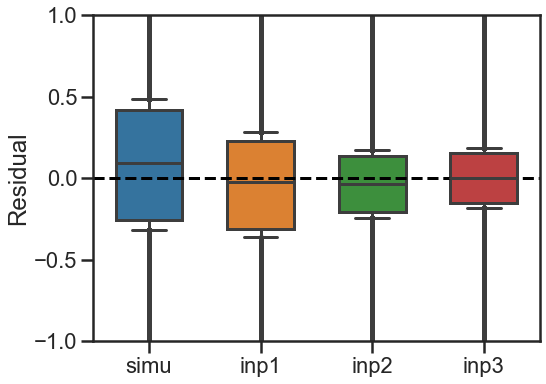

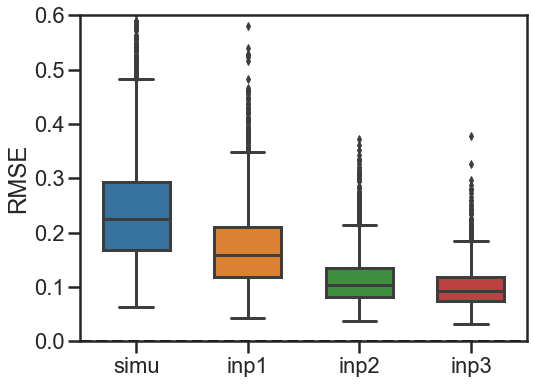

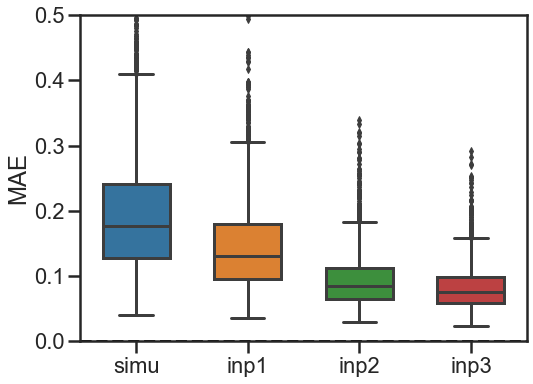

In [63]:
plt.figure(figsize=(8, 6))
ax = sns.boxplot(data=[residual_simu.ravel(), residual_pred1.ravel(), residual_pred2.ravel(), residual_pred3.ravel()], saturation=0.7, width=0.6, whis=0.1)
ax.set_xticklabels(['simu', 'inp1', 'inp2', 'inp3'])
plt.ylabel('Residual')
plt.ylim([-1, 1])
plt.plot(list(ax.get_xlim()), [0, 0], 'k--')
plt.savefig(os.path.join(fig_path, 'Residual.%s' % fig_fmt), dpi=300, bbox_inches='tight')

plt.figure(figsize=(8, 6))
ax = sns.boxplot(data=[MSE_simu, MSE_pred1, MSE_pred2, MSE_pred3], saturation=0.7, width=0.6)
ax.set_xticklabels(['simu', 'inp1', 'inp2', 'inp3'])
plt.ylabel('RMSE')
plt.ylim([0, 0.6])
plt.plot(list(ax.get_xlim()), [0, 0], 'k--')
plt.savefig(os.path.join(fig_path, 'RMSE.%s' % fig_fmt), dpi=300, bbox_inches='tight')

plt.figure(figsize=(8, 6))
ax = sns.boxplot(data=[MAE_simu, MAE_pred1, MAE_pred2, MAE_pred3], saturation=0.7, width=0.6)
ax.set_xticklabels(['simu', 'inp1', 'inp2', 'inp3'])
plt.ylabel('MAE')
plt.ylim([0, 0.5])
plt.plot(list(ax.get_xlim()), [0, 0], 'k--')
plt.savefig(os.path.join(fig_path, 'MAE.%s' % fig_fmt), dpi=300, bbox_inches='tight')

## 不同周期下residual的箱型图对比

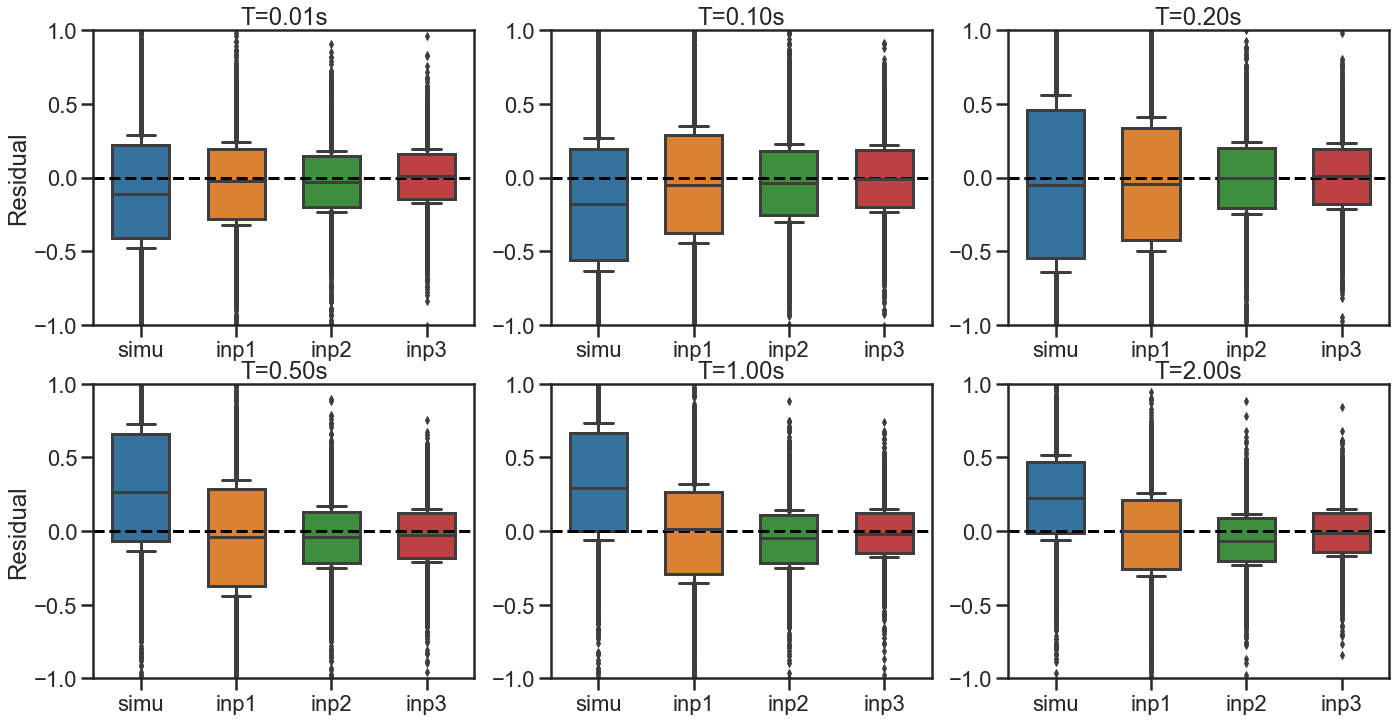

In [64]:
plt.figure(figsize=(18, 9))
plt.subplots_adjust(left=0,bottom=0,top=1,right=1,hspace=0.2,wspace=0.2)
for i, T in enumerate(period_sec):
    idx = np.argmin(np.abs(period - T))

    plt.subplot(2, 3, i + 1)
    ax = sns.boxplot(data=[residual_simu[:, idx, 0], residual_pred1[:, idx, 0], residual_pred2[:, idx, 0], residual_pred3[:, idx, 0]], saturation=0.7, width=0.6, whis=0.1)
    plt.ylim([-1, 1])
    plt.plot(list(ax.get_xlim()), [0, 0], 'k--')
    ax.set_xticklabels(['simu', 'inp1', 'inp2', 'inp3'])
    if i in [0, 3]:
        plt.ylabel('Residual')
    plt.title('T=%.2fs' % T, size=24)
    # plt.legend(loc='upper left')
plt.savefig(os.path.join(fig_path, 'Residual_periods.%s' % fig_fmt), dpi=300, bbox_inches='tight')

# 特定地震的对比

## 加载数据

In [ ]:
model_path = 'inp_arg3_model'
result_path = 'basic_3inps_100class_logsa2'
fig_fmt = 'png'
with open(os.path.join(model_path, 'data_preprocess_100class_logsa.pkl'), 'rb') as file:
    dataset = pickle.loads(file.read())
results = scipy.io.loadmat(os.path.join(model_path, result_path, 'result.mat'))
print(results.keys())
period = np.logspace(np.log10(0.01), np.log10(10), 200)
simu_data = np.load('Sa_simulate.npy', allow_pickle=True).item()

## 绘图

In [ ]:
import matplotlib
matplotlib.use('AGG')
data_type_list = ['test']

for data_type in data_type_list:

    if data_type == 'train':
        label = dataset.train_label
        pred = results['train_pred']
    elif data_type == 'valid':
        label = dataset.valid_label
        pred = results['valid_pred']
    else:
        label = dataset.test_label
        pred = results['test_pred']
    label = label * dataset.label_std + dataset.label_mean
    pbar = tqdm(range(len(label)), desc='Plotting', ncols=100)
    com_path = os.path.join(model_path, result_path, 'figs_com')
    if not os.path.exists(com_path):
        os.mkdir(com_path)
    err_ev = []
    for i in pbar:
        if data_type == 'train':
            ev = dataset.train_events[dataset.train_idx[i]]
        elif data_type == 'valid':
            ev = dataset.valid_events[dataset.valid_idx[i]]
        else:
            ev = dataset.test_events[dataset.test_idx[i]]
        pbar.set_description(ev)
        try:
            plt.figure(figsize=(16, 6))
            plt.subplot(1, 2, 1)
            plt.semilogx(period, 10 ** label[i, ...], 'k', label='target')
            plt.semilogx(period, 10 ** pred[i, ...], 'r', label='pred')
            plt.semilogx(period, 981 * simu_data[ev], 'b', label='simu')
            plt.xlabel('T (s)')
            plt.ylabel('Sa (gal)')
            # plt.yscale('log')
            plt.title(ev)
            plt.legend()
            plt.subplot(1, 2, 2)
            plt.semilogx(period, 10 ** label[i, ...], 'k', label='target')
            plt.semilogx(period, 10 ** pred[i, ...], 'r', label='pred')
            plt.semilogx(period, 981 * simu_data[ev], 'b', label='simu')
            plt.xlabel('T (s)')
            plt.ylabel('Sa (gal)')
            plt.yscale('log')
            plt.title(ev)
            plt.savefig(os.path.join(com_path, '%s-%s%d.%s' % (ev, data_type, i, fig_fmt)), dpi=150, bbox_inches='tight')
            plt.close()
        except:
            err_ev.append(ev)
    print(err_ev)

# 特定台站的对比

## 加载数据

In [70]:
model_path = 'inp_arg2_model_events'
result_path = 'basic_2inps_100class_logsa5'
fig_fmt = 'png'
with open(os.path.join(model_path, 'data_preprocess_100class_logsa.pkl'), 'rb') as file:
    dataset = pickle.loads(file.read())
results = scipy.io.loadmat(os.path.join(model_path, result_path, 'result.mat'))
print(results.keys())
period = np.logspace(np.log10(0.01), np.log10(10), 200)
simu_data = np.load('Sa_simulate.npy', allow_pickle=True).item()

dict_keys(['__header__', '__version__', '__globals__', 'train_pred', 'test_pred', 'valid_pred', 'train_loss', 'valid_loss', 'train_performance', 'valid_performance', 'test_performance'])


## 绘图

### 对于按台站划分的情况

In [ ]:
data_type_list = ['test', 'train', 'valid']
for data_type in data_type_list:

    if data_type == 'train':
        data = dataset.train_data[0]
        label = dataset.train_label
        pred = results['train_pred']
        stations = dataset.train_stations
    elif data_type == 'valid':
        data = dataset.valid_data[0]
        label = dataset.valid_label
        pred = results['valid_pred']
        stations = dataset.valid_stations
    else:
        data = dataset.test_data[0]
        label = dataset.test_label
        pred = results['test_pred']
        stations = dataset.test_stations
    data = data * dataset.data_std[0] + dataset.data_mean[0]
    label = label * dataset.label_std + dataset.label_mean
    com_path = os.path.join(model_path, result_path, 'figs_com_sta')
    if not os.path.exists(com_path):
        os.mkdir(com_path)
    
    pbar = tqdm(stations, desc=stations[0], ncols=100)
    for station in pbar:
        pbar.set_description(station)
        err_ev = []
        label_all, pred_all, simu_all = [], [], []
        for i in range(len(label)):
            if data_type == 'train':
                ev = dataset.train_events[dataset.train_idx[i]]
            elif data_type == 'valid':
                ev = dataset.valid_events[dataset.valid_idx[i]]
            else:
                ev = dataset.test_events[dataset.test_idx[i]]
            if station in ev:
                try:
                    label_amp = label[i, ...] - data[i, ...]
                    pred_amp = pred[i, ...] - data[i, ...]
                    simu_amp = np.log10(981 * simu_data[ev][:, None]) - data[i, ...]
                    label_all.append(label_amp)
                    pred_all.append(pred_amp)
                    simu_all.append(simu_amp)
                    # plt.subplot(1, 2, 1)
                    # plt.semilogx(period, 10 ** label_amp, 'k', linewidth=0.5, alpha=0.5)
                    # plt.semilogx(period, 10 ** pred_amp, 'r', linewidth=0.5, alpha=0.5)
                    # plt.semilogx(period, 10 ** simu_amp, 'b', linewidth=0.5, alpha=0.5)
                    # plt.xlabel('T (s)')
                    # plt.ylabel('Amp.')
                    # plt.subplot(1, 2, 2)
                    # plt.semilogx(period, 10 ** label_amp, 'k', linewidth=0.5, alpha=0.5)
                    # plt.semilogx(period, 10 ** pred_amp, 'r', linewidth=0.5, alpha=0.5)
                    # plt.semilogx(period, 10 ** simu_amp, 'b', linewidth=0.5, alpha=0.5)
                    # plt.xlabel('T (s)')
                    # # plt.ylabel('Amp.')
                    # plt.yscale('log')
                except:
                    err_ev.append(ev)
            else:
                continue
        if len(label_all) > 1:
            plt.figure(figsize=(16, 6))
            plt.subplot(1, 2, 1)
            label_mean, label_std = np.mean(10 ** np.array(label_all), axis=0), np.std(10 ** np.array(label_all), axis=0)
            pred_mean, pred_std = np.mean(10 ** np.array(pred_all), axis=0), np.std(10 ** np.array(pred_all), axis=0)
            simu_mean, simu_std = np.mean(10 ** np.array(simu_all), axis=0), np.std(10 ** np.array(simu_all), axis=0)
            plt.semilogx(period, label_mean, 'k', label='target')
            plt.fill_between(period, (label_mean - label_std).ravel(), (label_mean + label_std).ravel(), color='k', alpha=0.2)
            plt.semilogx(period, pred_mean, 'r', label='pred')
            plt.fill_between(period, (pred_mean - pred_std).ravel(), (pred_mean + pred_std).ravel(), color='r', alpha=0.2)
            plt.semilogx(period, simu_mean, 'b', label='simu')
            plt.fill_between(period, (simu_mean - simu_std).ravel(), (simu_mean + simu_std).ravel(), color='b', alpha=0.2)
            plt.xlabel('T (s)')
            plt.ylabel('Amp.')
            # plt.yscale('log')
            plt.title(station)
            plt.legend()
            plt.subplot(1, 2, 2)
            label_mean, label_std = 10 ** np.mean(np.array(label_all), axis=0), 10 ** np.std(np.array(label_all), axis=0)
            pred_mean, pred_std = 10 ** np.mean(np.array(pred_all), axis=0), 10 ** np.std(np.array(pred_all), axis=0)
            simu_mean, simu_std = 10 ** np.mean(np.array(simu_all), axis=0), 10 ** np.std(np.array(simu_all), axis=0)
            plt.semilogx(period, label_mean, 'k', label='target')
            plt.fill_between(period, (label_mean / label_std).ravel(), (label_mean * label_std).ravel(), color='k', alpha=0.2)
            plt.semilogx(period, pred_mean, 'r', label='pred')
            plt.fill_between(period, (pred_mean / pred_std).ravel(), (pred_mean * pred_std).ravel(), color='r', alpha=0.2)
            plt.semilogx(period, simu_mean, 'b', label='simu')
            plt.fill_between(period, (simu_mean / simu_std).ravel(), (simu_mean * simu_std).ravel(), color='b', alpha=0.2)
            plt.xlabel('T (s)')
            # plt.ylabel('Amp.')
            plt.yscale('log')
            plt.title(station)
            plt.legend()
            plt.savefig(os.path.join(com_path, '%s-%s.%s' % (station, data_type, fig_fmt)), dpi=150, bbox_inches='tight')
            plt.close()

### 对于按事件划分的情况

In [71]:
data_type_list = ['test', 'train', 'valid']
for data_type in data_type_list:

    if data_type == 'train':
        data = dataset.train_data[0]
        label = dataset.train_label
        pred = results['train_pred']
        stations = list(set([sta[:6] for sta in dataset.train_events]))
    elif data_type == 'valid':
        data = dataset.valid_data[0]
        label = dataset.valid_label
        pred = results['valid_pred']
        stations = list(set([sta[:6] for sta in dataset.valid_events]))
    else:
        data = dataset.test_data[0]
        label = dataset.test_label
        pred = results['test_pred']
        stations = list(set([sta[:6] for sta in dataset.test_events]))
    data = data * dataset.data_std[0] + dataset.data_mean[0]
    label = label * dataset.label_std + dataset.label_mean
    com_path = os.path.join(model_path, result_path, 'figs_com_sta')
    if not os.path.exists(com_path):
        os.mkdir(com_path)
    
    pbar = tqdm(stations, desc=stations[0], ncols=100)
    for station in pbar:
        pbar.set_description(station)
        err_ev = []
        label_all, pred_all, simu_all = [], [], []
        for i in range(len(label)):
            if data_type == 'train':
                ev = dataset.train_events[dataset.train_idx[i]]
            elif data_type == 'valid':
                ev = dataset.valid_events[dataset.valid_idx[i]]
            else:
                ev = dataset.test_events[dataset.test_idx[i]]
            if station in ev:
                try:
                    label_amp = label[i, ...] - data[i, ...]
                    pred_amp = pred[i, ...] - data[i, ...]
                    simu_amp = np.log10(981 * simu_data[ev][:, None]) - data[i, ...]
                    label_all.append(label_amp)
                    pred_all.append(pred_amp)
                    simu_all.append(simu_amp)
                    # plt.subplot(1, 2, 1)
                    # plt.semilogx(period, 10 ** label_amp, 'k', linewidth=0.5, alpha=0.5)
                    # plt.semilogx(period, 10 ** pred_amp, 'r', linewidth=0.5, alpha=0.5)
                    # plt.semilogx(period, 10 ** simu_amp, 'b', linewidth=0.5, alpha=0.5)
                    # plt.xlabel('T (s)')
                    # plt.ylabel('Amp.')
                    # plt.subplot(1, 2, 2)
                    # plt.semilogx(period, 10 ** label_amp, 'k', linewidth=0.5, alpha=0.5)
                    # plt.semilogx(period, 10 ** pred_amp, 'r', linewidth=0.5, alpha=0.5)
                    # plt.semilogx(period, 10 ** simu_amp, 'b', linewidth=0.5, alpha=0.5)
                    # plt.xlabel('T (s)')
                    # # plt.ylabel('Amp.')
                    # plt.yscale('log')
                except:
                    err_ev.append(ev)
            else:
                continue
        if len(label_all) > 1:
            plt.figure(figsize=(16, 6))
            plt.subplot(1, 2, 1)
            label_mean, label_std = np.mean(10 ** np.array(label_all), axis=0), np.std(10 ** np.array(label_all), axis=0)
            pred_mean, pred_std = np.mean(10 ** np.array(pred_all), axis=0), np.std(10 ** np.array(pred_all), axis=0)
            simu_mean, simu_std = np.mean(10 ** np.array(simu_all), axis=0), np.std(10 ** np.array(simu_all), axis=0)
            plt.semilogx(period, label_mean, 'k', label='target')
            plt.fill_between(period, (label_mean - label_std).ravel(), (label_mean + label_std).ravel(), color='k', alpha=0.2)
            plt.semilogx(period, pred_mean, 'r', label='pred')
            plt.fill_between(period, (pred_mean - pred_std).ravel(), (pred_mean + pred_std).ravel(), color='r', alpha=0.2)
            plt.semilogx(period, simu_mean, 'b', label='simu')
            plt.fill_between(period, (simu_mean - simu_std).ravel(), (simu_mean + simu_std).ravel(), color='b', alpha=0.2)
            plt.xlabel('T (s)')
            plt.ylabel('Amp.')
            # plt.yscale('log')
            plt.title(station)
            plt.legend()
            plt.subplot(1, 2, 2)
            label_mean, label_std = 10 ** np.mean(np.array(label_all), axis=0), 10 ** np.std(np.array(label_all), axis=0)
            pred_mean, pred_std = 10 ** np.mean(np.array(pred_all), axis=0), 10 ** np.std(np.array(pred_all), axis=0)
            simu_mean, simu_std = 10 ** np.mean(np.array(simu_all), axis=0), 10 ** np.std(np.array(simu_all), axis=0)
            plt.semilogx(period, label_mean, 'k', label='target')
            plt.fill_between(period, (label_mean / label_std).ravel(), (label_mean * label_std).ravel(), color='k', alpha=0.2)
            plt.semilogx(period, pred_mean, 'r', label='pred')
            plt.fill_between(period, (pred_mean / pred_std).ravel(), (pred_mean * pred_std).ravel(), color='r', alpha=0.2)
            plt.semilogx(period, simu_mean, 'b', label='simu')
            plt.fill_between(period, (simu_mean / simu_std).ravel(), (simu_mean * simu_std).ravel(), color='b', alpha=0.2)
            plt.xlabel('T (s)')
            # plt.ylabel('Amp.')
            plt.yscale('log')
            plt.title(station)
            plt.legend()
            plt.savefig(os.path.join(com_path, '%s-%s.%s' % (station, data_type, fig_fmt)), dpi=150, bbox_inches='tight')
            plt.close()

IWTH09: 100%|█████████████████████████████████████████████████████| 133/133 [02:02<00:00,  1.09it/s]


# 特定台站对比——傅里叶谱

## 加载数据

In [79]:
model_path = 'inp_arg2_model_events'
result_path = 'basic_2inps_100class_fts3'
fig_fmt = 'png'
with open(os.path.join(model_path, 'data_preprocess_100class_logFTS.pkl'), 'rb') as file:
    dataset = pickle.loads(file.read())
results = scipy.io.loadmat(os.path.join(model_path, result_path, 'result.mat'))
print(results.keys())
freq = np.logspace(np.log10(0.1), np.log10(25), 500)
simu_data = np.load('FTS_simulate.npy', allow_pickle=True).item()

dict_keys(['__header__', '__version__', '__globals__', 'train_pred', 'test_pred', 'valid_pred', 'train_loss', 'valid_loss', 'train_performance', 'valid_performance', 'test_performance'])


## 绘图

### 对于按台站划分的情况

In [ ]:
data_type_list = ['test', 'train', 'valid']
for data_type in data_type_list:

    if data_type == 'train':
        data = dataset.train_data[0]
        label = dataset.train_label
        pred = results['train_pred']
        stations = dataset.train_stations
    elif data_type == 'valid':
        data = dataset.valid_data[0]
        label = dataset.valid_label
        pred = results['valid_pred']
        stations = dataset.valid_stations
    else:
        data = dataset.test_data[0]
        label = dataset.test_label
        pred = results['test_pred']
        stations = dataset.test_stations
    data = data * dataset.data_std[0] + dataset.data_mean[0]
    label = label * dataset.label_std + dataset.label_mean
    com_path = os.path.join(model_path, result_path, 'figs_com_sta')
    if not os.path.exists(com_path):
        os.mkdir(com_path)
    
    pbar = tqdm(stations, desc=stations[0], ncols=100)
    for station in pbar:
        pbar.set_description(station)
        err_ev = []
        label_all, pred_all, simu_all = [], [], []
        for i in range(len(label)):
            if data_type == 'train':
                ev = dataset.train_events[dataset.train_idx[i]]
            elif data_type == 'valid':
                ev = dataset.valid_events[dataset.valid_idx[i]]
            else:
                ev = dataset.test_events[dataset.test_idx[i]]
            if station in ev:
                try:
                    label_amp = label[i, ...] - data[i, ...]
                    pred_amp = pred[i, ...] - data[i, ...]
                    simu_amp = np.log10(981 * simu_data[ev][:, None]) - data[i, ...]
                    label_all.append(label_amp)
                    pred_all.append(pred_amp)
                    simu_all.append(simu_amp)
                    # plt.subplot(1, 2, 1)
                    # plt.semilogx(period, 10 ** label_amp, 'k', linewidth=0.5, alpha=0.5)
                    # plt.semilogx(period, 10 ** pred_amp, 'r', linewidth=0.5, alpha=0.5)
                    # plt.semilogx(period, 10 ** simu_amp, 'b', linewidth=0.5, alpha=0.5)
                    # plt.xlabel('T (s)')
                    # plt.ylabel('Amp.')
                    # plt.subplot(1, 2, 2)
                    # plt.semilogx(period, 10 ** label_amp, 'k', linewidth=0.5, alpha=0.5)
                    # plt.semilogx(period, 10 ** pred_amp, 'r', linewidth=0.5, alpha=0.5)
                    # plt.semilogx(period, 10 ** simu_amp, 'b', linewidth=0.5, alpha=0.5)
                    # plt.xlabel('T (s)')
                    # # plt.ylabel('Amp.')
                    # plt.yscale('log')
                except:
                    err_ev.append(ev)
            else:
                continue
        if len(label_all) > 1:
            plt.figure(figsize=(16, 6))
            plt.subplot(1, 2, 1)
            label_mean, label_std = np.mean(10 ** np.array(label_all), axis=0), np.std(10 ** np.array(label_all), axis=0)
            pred_mean, pred_std = np.mean(10 ** np.array(pred_all), axis=0), np.std(10 ** np.array(pred_all), axis=0)
            simu_mean, simu_std = np.mean(10 ** np.array(simu_all), axis=0), np.std(10 ** np.array(simu_all), axis=0)
            plt.semilogx(freq, label_mean, 'k', label='target')
            plt.fill_between(freq, (label_mean - label_std).ravel(), (label_mean + label_std).ravel(), color='k', alpha=0.2)
            plt.semilogx(freq, pred_mean, 'r', label='pred')
            plt.fill_between(freq, (pred_mean - pred_std).ravel(), (pred_mean + pred_std).ravel(), color='r', alpha=0.2)
            plt.semilogx(freq, simu_mean, 'b', label='simu')
            plt.fill_between(freq, (simu_mean - simu_std).ravel(), (simu_mean + simu_std).ravel(), color='b', alpha=0.2)
            plt.xlabel('T (s)')
            plt.ylabel('Amp.')
            # plt.yscale('log')
            plt.title(station)
            plt.legend()
            plt.subplot(1, 2, 2)
            label_mean, label_std = 10 ** np.mean(np.array(label_all), axis=0), 10 ** np.std(np.array(label_all), axis=0)
            pred_mean, pred_std = 10 ** np.mean(np.array(pred_all), axis=0), 10 ** np.std(np.array(pred_all), axis=0)
            simu_mean, simu_std = 10 ** np.mean(np.array(simu_all), axis=0), 10 ** np.std(np.array(simu_all), axis=0)
            plt.semilogx(freq, label_mean, 'k', label='target')
            plt.fill_between(freq, (label_mean / label_std).ravel(), (label_mean * label_std).ravel(), color='k', alpha=0.2)
            plt.semilogx(freq, pred_mean, 'r', label='pred')
            plt.fill_between(freq, (pred_mean / pred_std).ravel(), (pred_mean * pred_std).ravel(), color='r', alpha=0.2)
            plt.semilogx(freq, simu_mean, 'b', label='simu')
            plt.fill_between(freq, (simu_mean / simu_std).ravel(), (simu_mean * simu_std).ravel(), color='b', alpha=0.2)
            plt.xlabel('T (s)')
            # plt.ylabel('Amp.')
            plt.yscale('log')
            plt.title(station)
            plt.legend()
            plt.savefig(os.path.join(com_path, '%s-%s.%s' % (station, data_type, fig_fmt)), dpi=150, bbox_inches='tight')
            plt.close()

### 对于按事件划分的情况

In [80]:
data_type_list = ['test', 'train', 'valid']
for data_type in data_type_list:

    if data_type == 'train':
        data = dataset.train_data[0]
        label = dataset.train_label
        pred = results['train_pred']
        stations = list(set([sta[:6] for sta in dataset.train_events]))
    elif data_type == 'valid':
        data = dataset.valid_data[0]
        label = dataset.valid_label
        pred = results['valid_pred']
        stations = list(set([sta[:6] for sta in dataset.valid_events]))
    else:
        data = dataset.test_data[0]
        label = dataset.test_label
        pred = results['test_pred']
        stations = list(set([sta[:6] for sta in dataset.test_events]))
    data = data * dataset.data_std[0] + dataset.data_mean[0]
    label = label * dataset.label_std + dataset.label_mean
    com_path = os.path.join(model_path, result_path, 'figs_com_sta')
    if not os.path.exists(com_path):
        os.mkdir(com_path)
    
    pbar = tqdm(stations, desc=stations[0], ncols=100)
    for station in pbar:
        pbar.set_description(station)
        err_ev = []
        label_all, pred_all, simu_all = [], [], []
        for i in range(len(label)):
            if data_type == 'train':
                ev = dataset.train_events[dataset.train_idx[i]]
            elif data_type == 'valid':
                ev = dataset.valid_events[dataset.valid_idx[i]]
            else:
                ev = dataset.test_events[dataset.test_idx[i]]
            if station in ev:
                try:
                    label_amp = label[i, ...] - data[i, ...]
                    pred_amp = pred[i, ...] - data[i, ...]
                    simu_amp = np.log10(981 * simu_data[ev][:, None]) - data[i, ...]
                    label_all.append(label_amp)
                    pred_all.append(pred_amp)
                    simu_all.append(simu_amp)
                    # plt.subplot(1, 2, 1)
                    # plt.semilogx(period, 10 ** label_amp, 'k', linewidth=0.5, alpha=0.5)
                    # plt.semilogx(period, 10 ** pred_amp, 'r', linewidth=0.5, alpha=0.5)
                    # plt.semilogx(period, 10 ** simu_amp, 'b', linewidth=0.5, alpha=0.5)
                    # plt.xlabel('T (s)')
                    # plt.ylabel('Amp.')
                    # plt.subplot(1, 2, 2)
                    # plt.semilogx(period, 10 ** label_amp, 'k', linewidth=0.5, alpha=0.5)
                    # plt.semilogx(period, 10 ** pred_amp, 'r', linewidth=0.5, alpha=0.5)
                    # plt.semilogx(period, 10 ** simu_amp, 'b', linewidth=0.5, alpha=0.5)
                    # plt.xlabel('T (s)')
                    # # plt.ylabel('Amp.')
                    # plt.yscale('log')
                except:
                    err_ev.append(ev)
            else:
                continue
        if len(label_all) > 1:
            plt.figure(figsize=(16, 6))
            plt.subplot(1, 2, 1)
            label_mean, label_std = np.mean(10 ** np.array(label_all), axis=0), np.std(10 ** np.array(label_all), axis=0)
            pred_mean, pred_std = np.mean(10 ** np.array(pred_all), axis=0), np.std(10 ** np.array(pred_all), axis=0)
            simu_mean, simu_std = np.mean(10 ** np.array(simu_all), axis=0), np.std(10 ** np.array(simu_all), axis=0)
            plt.semilogx(freq, label_mean, 'k', label='target')
            plt.fill_between(freq, (label_mean - label_std).ravel(), (label_mean + label_std).ravel(), color='k', alpha=0.2)
            plt.semilogx(freq, pred_mean, 'r', label='pred')
            plt.fill_between(freq, (pred_mean - pred_std).ravel(), (pred_mean + pred_std).ravel(), color='r', alpha=0.2)
            plt.semilogx(freq, simu_mean, 'b', label='simu')
            plt.fill_between(freq, (simu_mean - simu_std).ravel(), (simu_mean + simu_std).ravel(), color='b', alpha=0.2)
            plt.xlabel('T (s)')
            plt.ylabel('Amp.')
            # plt.yscale('log')
            plt.title(station)
            plt.legend()
            plt.subplot(1, 2, 2)
            label_mean, label_std = 10 ** np.mean(np.array(label_all), axis=0), 10 ** np.std(np.array(label_all), axis=0)
            pred_mean, pred_std = 10 ** np.mean(np.array(pred_all), axis=0), 10 ** np.std(np.array(pred_all), axis=0)
            simu_mean, simu_std = 10 ** np.mean(np.array(simu_all), axis=0), 10 ** np.std(np.array(simu_all), axis=0)
            plt.semilogx(freq, label_mean, 'k', label='target')
            plt.fill_between(freq, (label_mean / label_std).ravel(), (label_mean * label_std).ravel(), color='k', alpha=0.2)
            plt.semilogx(freq, pred_mean, 'r', label='pred')
            plt.fill_between(freq, (pred_mean / pred_std).ravel(), (pred_mean * pred_std).ravel(), color='r', alpha=0.2)
            plt.semilogx(freq, simu_mean, 'b', label='simu')
            plt.fill_between(freq, (simu_mean / simu_std).ravel(), (simu_mean * simu_std).ravel(), color='b', alpha=0.2)
            plt.xlabel('T (s)')
            # plt.ylabel('Amp.')
            plt.yscale('log')
            plt.title(station)
            plt.legend()
            plt.savefig(os.path.join(com_path, '%s-%s.%s' % (station, data_type, fig_fmt)), dpi=150, bbox_inches='tight')
            plt.close()

IWTH09: 100%|█████████████████████████████████████████████████████| 133/133 [01:47<00:00,  1.24it/s]
